In [1]:
# # Diagnostic timing for FAE top-k and a faster fallback approach
# import time
# import tracemalloc
# import gc
# from PAMI.frequentPattern.basic import FPGrowth
# from PAMI.frequentPattern.topk import FAE

# file_name = 'td_freq_db_comp_graphics.csv'
# ks = [100, 250, 500]

# results = []

# for k in ks:
#     gc.collect()
#     tracemalloc.start()
#     t0 = time.time()
#     obj = FAE.FAE(file_name, k=k)
#     obj.mine()
#     runtime = time.time() - t0
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     results.append((k, 'FAE', runtime, peak/1024))
#     print(f'FAE k={k}: runtime={runtime:.2f}s, peak_mem={peak/1024:.1f}KB, patterns={len(obj.getPatterns())}')

# # Faster fallback: run FPGrowth with a low minSup to get candidate patterns then select top-k by support
# # This often is much faster on small datasets and avoids expensive top-k-specific computations
# for k in ks:
#     gc.collect()
#     tracemalloc.start()
#     t0 = time.time()
#     # choose minSup heuristically (1 or 2) for small DB
#     fp = FPGrowth.FPGrowth(file_name, minSup=1)
#     fp.mine()
#     patterns_df = fp.getPatternsAsDataFrame() if hasattr(fp, 'getPatternsAsDataFrame') else pd.DataFrame(obj.getPatterns())
#     # assume patterns_df has 'support' column
#     if 'support' in patterns_df.columns:
#         topk = patterns_df.nlargest(k, 'support')
#     else:
#         # fallback: sort by length and frequency combined
#         patterns_df['support'] = patterns_df.get('frequency', 0)
#         topk = patterns_df.nlargest(k, 'support')
#     runtime = time.time() - t0
#     current, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     results.append((k, 'FPGrowth+select', runtime, peak/1024))
#     print(f'FPGrowth+select k={k}: runtime={runtime:.2f}s, peak_mem={peak/1024:.1f}KB, selected={len(topk)}')

# print('\nSummary results:')
# import pandas as pd
# print(pd.DataFrame(results, columns=['k','method','runtime_s','peak_kb']))

# Data Mining Lab 1
In this lab session we will focus on the use of scientific computing libraries to efficiently process, transform, and manage data. We will also provide best practices and introduce visualization tools for effectively conducting big data analysis. Furthermore, we will show you how to implement basic classification techniques.

In [2]:
# test code for environment setup
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt') # download the NLTK datasets
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import math
# If you get "ModuleNotFoundError: No module named 'PAMI'"
# run the following in a new Jupyter cell:
# !pip3 install PAMI
import PAMI
import umap

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\A2282\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---

## Table of Contents
**Phase 1**
1. Data Source
2. Data Preparation
3. Data Transformation
 - 3.1 Converting Dictionary into Pandas dataframe
 - 3.2 Familiarizing yourself with the Data
4. Data Mining using Pandas
 - 4.1 Dealing with Missing Values
 - 4.2 Dealing with Duplicate Data
5. Data Preprocessing
 - 5.1 Sampling
 - 5.2 Feature Creation
 - 5.3 Feature Subset Selection
 - 5.4 Atrribute Transformation / Aggregation
   - 5.4.1 Transform Text Data

**Phase 2**
   - 5.4.2 Frequent Pattern Mining
 - 5.5 Dimensionality Reduction
 - 5.6 Discretization and Binarization
6. Data Exploration
7. Data Classification
8. Conclusion
9. References

---

## Introduction
In this notebook I will explore a text-based, document-based [dataset](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) using scientific computing tools such as Pandas and Numpy. In addition, several fundamental Data Mining concepts will be explored and explained in details, ranging from calculating distance measures to computing term frequency vectors. Coding examples, visualizations and demonstrations will be provided where necessary. Furthermore, additional exercises are provided after special topics. These exercises are geared towards testing the proficiency of students and motivate students to explore beyond the techniques covered in the notebook. 

---

### Requirements
Here are the computing and software requirements

#### Computing Resources
- Operating system: Preferably Linux or MacOS
- RAM: 8 GB
- Disk space: Mininium 8 GB

#### Software Requirements
Here is a list of the required programs and libraries necessary for this lab session:

##### Language:
- [Python 3+](https://www.python.org/download/releases/3.0/) (Note: coding will be done strictly on Python 3)
    - We are using Python 3.11.0.
    - You can use newer version, but use at your own risk.
    
##### Environment:
We recommend using [**uv**](https://github.com/astral-sh/uv), a fast Python package and environment manager developed by Astral.
See [README.md](README.md) for the setup instruction

##### Necessary Libraries:
- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install `jupyter` and Use `$jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install `sklearn` latest python library
- [Pandas](http://pandas.pydata.org/)
    - Install `pandas` python library
- [Numpy](http://www.numpy.org/)
    - Install `numpy` python library
- [Matplotlib](https://matplotlib.org/)
    - Install `maplotlib` for python (version 3.7.3 recommended, pip install matplotlib==3.7.3)
- [Plotly](https://plot.ly/)
    - Install and signup for `plotly`
- [Seaborn](https://seaborn.pydata.org/)
    - Install and signup for `seaborn`
- [NLTK](http://www.nltk.org/)
    - Install `nltk` library
- [PAMI](https://github.com/UdayLab/PAMI?tab=readme-ov-file)
    - Install `PAMI` library
- [UMAP](https://umap-learn.readthedocs.io/en/latest/)
    - Install `UMAP` library

---

In [3]:
# TEST necessary for when working with external scripts
%load_ext autoreload
%autoreload 2

In [4]:
import sys
print(sys.executable) # c:\<your path to the project directory>\.venv\Scripts\python.exe
print(sys.version) #3.11.0

c:\Users\A2282\Downloads\DataMine\DM2025Labs\DM2025-Lab1-Exercise\.venv\Scripts\python.exe
3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


## 1. The Data
In this notebook we will explore the popular 20 newsgroup dataset, originally provided [here](http://qwone.com/~jason/20Newsgroups/). The dataset is called "Twenty Newsgroups", which means there are 20 categories of news articles available in the entire dataset. A short description of the dataset, provided by the authors, is provided below:

- *The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.*

If you need more information about the dataset please refer to the reference provided above. Below is a snapshot of the dataset already converted into a table. Keep in mind that the original dataset is not in this nice pretty format. That work is left to us. That is one of the tasks that will be covered in this notebook: how to convert raw data into convenient tabular formats using Pandas. 

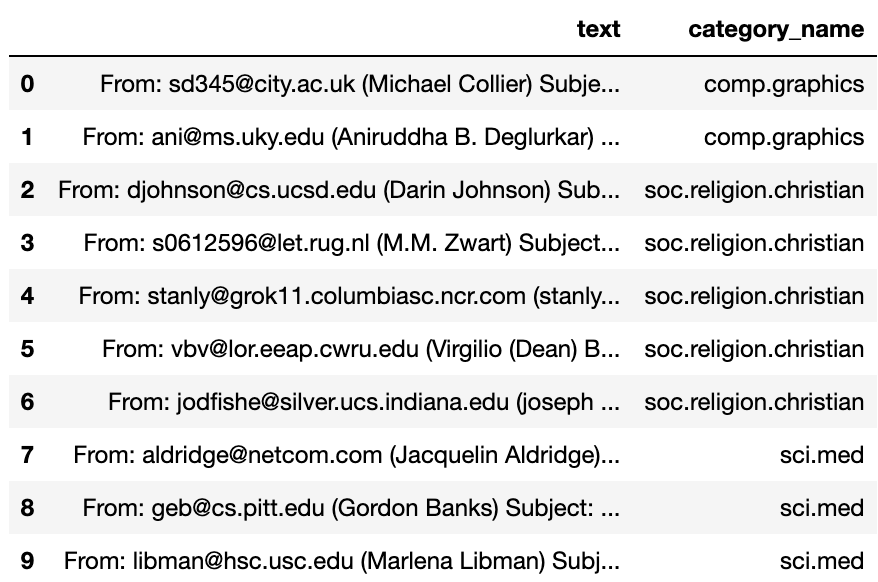

---

## 2. Data Preparation
In the following we will use the built-in dataset loader for 20 newsgroups from scikit-learn. Alternatively, it is possible to download the dataset manually from the website and use the sklearn.datasets.load_files function by pointing it to the 20news-bydate-train sub-folder of the uncompressed archive folder.

In order to get faster execution times for this first example we will work on a partial dataset with only 4 categories out of the 20 available in the dataset:

In [5]:
# categories
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

In [6]:
# obtain the documents containing the categories provided
from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=42) 
#This command also shuffles the data randomly, but with random_state we can bring the same distribution of data everytime 
#if we choose the same number, in this case "42". This is good for us, it means we can reproduce the same results every time
#we want to run the code.

Let's take a look at some of the records that are contained in our subset of the data

In [7]:
twenty_train.data[0:2]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

**Note** the `twenty_train` is just a bunch of objects that can be accessed as python dictionaries; so, you can do the following operations on `twenty_train`

In [8]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [9]:
len(twenty_train.data)

2257

In [10]:
len(twenty_train.filenames)

2257

#### We can also print an example from the subset

In [11]:
# An example of what the subset contains
print("\n".join(twenty_train.data[0].split("\n")))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



... and determine the label of the example via `target_names` key value

In [12]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


In [13]:
twenty_train.target[0]

np.int64(1)

... we can also get the category of 10 documents via `target` key value 

In [14]:
# category of first 10 documents.
twenty_train.target[0:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2])

**Note:** As you can observe, both approaches above provide two different ways of obtaining the `category` value for the dataset. Ideally, we want to have access to both types -- numerical and nominal -- in the event some particular library favors a particular type. 

As you may have already noticed as well, there is no **tabular format** for the current version of the data. As data miners, we are interested in having our dataset in the most convenient format as possible; something we can manipulate easily and is compatible with our algorithms, and so forth.

Here is one way to get access to the *text* version of the label of a subset of our training data:

In [15]:
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


---

### **>>> Exercise 1 (Watch Video):**  
In this exercise, please print out the *text* data for the first three samples in the dataset. (See the above code for help)

In [16]:
# Answer here
for i in range(3):
    print(f"example {i+1}")
    print("\n".join(twenty_train.data[i].split("\n")))

example 1
From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.

example 2
From: ani@ms.uky.edu (Aniruddha B. Deglurkar)
Subject: help: Splitting a trimming region along a mesh 
Organization: University Of Kentucky, Dept. of Math Sciences
Lines: 28



	Hi,

	I have a problem, I hope some of the 'gurus' can help me solve.

	Background of the problem:
	I have a rectan

---

## 3. Data Transformation
So we want to explore and understand our data a little bit better. Before we do that we definitely need to apply some transformations just so we can have our dataset in a nice format to be able to explore it freely and more efficient. Lucky for us, there are powerful scientific tools to transform our data into that tabular format we are so farmiliar with. So that is what we will do in the next section--transform our data into a nice table format.

---

### 3.1 Converting Dictionary into Pandas Dataframe
Here we will show you how to convert dictionary objects into a pandas dataframe. And by the way, a pandas dataframe is nothing more than a table magically stored for efficient information retrieval.

In [17]:
import pandas as pd

# my functions
import helpers.data_mining_helpers as dmh

# construct dataframe from a list
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])

In [18]:
len(X)

2257

In [19]:
X[0:2]

,text
0,From: sd345@city.ac.uk (Michael Collier) Subje...
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...


In [20]:
for t in X["text"][:2]:
    print(t)

From: sd345@city.ac.uk (Michael Collier) Subject: Converting images to HP LaserJet III? Nntp-Posting-Host: hampton Organization: The City University Lines: 14  Does anyone know of a good way (standard PC application/PD utility) to convert tif/img/tga files into LaserJet III format.  We would also like to do the same, converting to HPGL (HP plotter) files.  Please email any response.  Is this the correct group?  Thanks in advance.  Michael. --  Michael Collier (Programmer)                 The Computer Unit, Email: M.P.Collier@uk.ac.city                The City University, Tel: 071 477-8000 x3769                      London, Fax: 071 477-8565                            EC1V 0HB. 
From: ani@ms.uky.edu (Aniruddha B. Deglurkar) Subject: help: Splitting a trimming region along a mesh  Organization: University Of Kentucky, Dept. of Math Sciences Lines: 28    	Hi,  	I have a problem, I hope some of the 'gurus' can help me solve.  	Background of the problem: 	I have a rectangular mesh in the uv

### Adding Columns

One of the great advantages of a pandas dataframe is its flexibility. We can add columns to the current dataset programmatically with very little effort.

In [21]:
# add category to the dataframe
X['category'] = twenty_train.target

In [22]:
# add category label also
X['category_name'] = X.category.apply(lambda t: dmh.format_labels(t, twenty_train))

Now we can print and see what our table looks like. 

In [23]:
X[0:10]

,text,category,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,2,sci.med


Nice! Isn't it? With this format we can conduct many operations easily and efficiently since Pandas dataframes provide us with a wide range of built-in features/functionalities. These features are operations which can directly and quickly be applied to the dataset. These operations may include standard operations like **removing records with missing values** and **aggregating new fields** to the current table (hereinafter referred to as a dataframe), which is desirable in almost every data mining project. Go Pandas!

---

### 3.2 Familiarizing yourself with the Data

To begin to show you the awesomeness of Pandas dataframes, let us look at how to run a simple query on our dataset. We want to query for the first 10 rows (documents), and we only want to keep the `text` and `category_name` attributes or fields.

In [24]:
# a simple query
X[:10][["text","category_name"]]

,text,category_name
0,From: sd345@city.ac.uk (Michael Collier) Subje...,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,soc.religion.christian
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,soc.religion.christian
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,soc.religion.christian
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,sci.med
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,sci.med
9,From: libman@hsc.usc.edu (Marlena Libman) Subj...,sci.med


Let us look at a few more interesting queries to familiarize ourselves with the efficiency and conveniency of Pandas dataframes.

#### Let's query the last 10 records

In [25]:
X[-10:]

,text,category,category_name
2247,From: daniels@math.ufl.edu (TV's Big Dealer) S...,3,soc.religion.christian
2248,"From: ""danny hawrysio"" <danny.hawrysio@canrem....",1,comp.graphics
2249,From: shellgate!llo@uu4.psi.com (Larry L. Over...,3,soc.religion.christian
2250,From: ingles@engin.umich.edu (Ray Ingles) Subj...,0,alt.atheism
2251,From: Mark-Tarbell@suite.com Subject: Amniocen...,2,sci.med
2252,From: roos@Operoni.Helsinki.FI (Christophe Roo...,2,sci.med
2253,From: mhollowa@ic.sunysb.edu (Michael Holloway...,2,sci.med
2254,From: sasghm@theseus.unx.sas.com (Gary Merrill...,2,sci.med
2255,From: Dan Wallach <dwallach@cs.berkeley.edu> S...,2,sci.med
2256,From: dyer@spdcc.com (Steve Dyer) Subject: Re:...,2,sci.med


Ready for some sourcery? Brace yourselves! Let us see if we can query the first 10th record in our dataframe. For this we will use the build-in function called `loc`. This allows us to explicity define the columns you want to query.

In [26]:
# using loc (by label)
X.loc[:10, 'text']

0     From: sd345@city.ac.uk (Michael Collier) Subje...
1     From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...
2     From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...
3     From: s0612596@let.rug.nl (M.M. Zwart) Subject...
4     From: stanly@grok11.columbiasc.ncr.com (stanly...
5     From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...
6     From: jodfishe@silver.ucs.indiana.edu (joseph ...
7     From: aldridge@netcom.com (Jacquelin Aldridge)...
8     From: geb@cs.pitt.edu (Gordon Banks) Subject: ...
9     From: libman@hsc.usc.edu (Marlena Libman) Subj...
10    From: anasaz!karl@anasazi.com (Karl Dussik) Su...
Name: text, dtype: object

You can also use the `iloc` function to query a selection of our dataset by position. Take a look at this [great discussion](https://stackoverflow.com/questions/28757389/pandas-loc-vs-iloc-vs-ix-vs-at-vs-iat/43968774) on the differences between the `iloc` and `loc` functions.

In [27]:
# using iloc (by position)
X.iloc[:10, 0]

0    From: sd345@city.ac.uk (Michael Collier) Subje...
1    From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...
2    From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...
3    From: s0612596@let.rug.nl (M.M. Zwart) Subject...
4    From: stanly@grok11.columbiasc.ncr.com (stanly...
5    From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...
6    From: jodfishe@silver.ucs.indiana.edu (joseph ...
7    From: aldridge@netcom.com (Jacquelin Aldridge)...
8    From: geb@cs.pitt.edu (Gordon Banks) Subject: ...
9    From: libman@hsc.usc.edu (Marlena Libman) Subj...
Name: text, dtype: object

### **>>> Exercise 2 (take home):** 
Experiment with other querying techniques using pandas dataframes. Refer to their [documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html) for more information. 

In [28]:
#Answer here

X[:10:-1][["category_name","text"]]

,category_name,text
2256,sci.med,From: dyer@spdcc.com (Steve Dyer) Subject: Re:...
2255,sci.med,From: Dan Wallach <dwallach@cs.berkeley.edu> S...
2254,sci.med,From: sasghm@theseus.unx.sas.com (Gary Merrill...
2253,sci.med,From: mhollowa@ic.sunysb.edu (Michael Holloway...
2252,sci.med,From: roos@Operoni.Helsinki.FI (Christophe Roo...
...,...,...
15,comp.graphics,From: Mike_Peredo@mindlink.bc.ca (Mike Peredo)...
14,comp.graphics,From: sloan@cis.uab.edu (Kenneth Sloan) Subjec...
13,alt.atheism,Subject: So what is Maddi? From: madhaus@netco...
12,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...


---

### **>>> Exercise 3 (Watch Video):**  
Try to fetch records belonging to the ```sci.med``` category, and query every 10th record. Only show the first 5 records.

In [29]:
# Answer here
X[X['category_name']=='sci.med'][::10][0:5]

,text,category,category_name
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
49,From: jimj@contractor.EBay.Sun.COM (Jim Jones)...,2,sci.med
82,From: jason@ab20.larc.nasa.gov (Jason Austin) ...,2,sci.med
118,From: rogers@calamari.hi.com (Andrew Rogers) S...,2,sci.med
142,From: lady@uhunix.uhcc.Hawaii.Edu (Lee Lady) S...,2,sci.med


---

## 4. Data Mining using Pandas

Let's do some serious work now. Let's learn to program some of the ideas and concepts learned so far in the data mining course. This is the only way we can convince ourselves of the true power of Pandas dataframes. 

### 4.1 Missing Values

First, let us consider that our dataset has some *missing values* and we want to remove those values. In its current state our dataset has no missing values, but for practice sake we will add some records with missing values and then write some code to deal with these objects that contain missing values. You will see for yourself how easy it is to deal with missing values once you have your data transformed into a Pandas dataframe.

Before we jump into coding, let us do a quick review of what we have learned in the Data Mining course. Specifically, let's review the methods used to deal with missing values.

The most common reasons for having missing values in datasets has to do with how the data was initially collected. A good example of this is when a patient comes into the ER room, the data is collected as quickly as possible and depending on the conditions of the patients, the personal data being collected is either incomplete or partially complete. In the former and latter cases, we are presented with a case of "missing values". Knowing that patients data is particularly critical and can be used by the health authorities to conduct some interesting analysis, we as the data miners are left with the tough task of deciding what to do with these missing and incomplete records. We need to deal with these records because they are definitely going to affect our analysis or learning algorithms. So what do we do? There are several ways to handle missing values, and some of the more effective ways are presented below (Note: You can reference the slides - Session 1 Handout for the additional information).

- **Eliminate Data Objects** - Here we completely discard records once they contain some missing values. This is the easiest approach and the one we will be using in this notebook. The immediate drawback of going with this approach is that you lose some information, and in some cases too much of it. Now imagine that half of the records have at least one or more missing values. Here you are presented with the tough decision of quantity vs quality. In any event, this decision must be made carefully, hence the reason for emphasizing it here in this notebook. 

- **Estimate Missing Values** - Here we try to estimate the missing values based on some criteria. Although this approach may be proven to be effective, it is not always the case, especially when we are dealing with sensitive data, like **Gender** or **Names**. For fields like **Address**, there could be ways to obtain these missing addresses using some data aggregation technique or obtain the information directly from other databases or public data sources.

- **Ignore the missing value during analysis** - Here we basically ignore the missing values and proceed with our analysis. Although this is the most naive way to handle missing values it may proof effective, especially when the missing values includes information that is not important to the analysis being conducted. But think about it for a while. Would you ignore missing values, especially when in this day and age it is difficult to obtain high quality datasets? Again, there are some tradeoffs, which we will talk about later in the notebook.

- **Replace with all possible values** - As an efficient and responsible data miner, we sometimes just need to put in the hard hours of work and find ways to makes up for these missing values. This last option is a very wise option for cases where data is scarce (which is almost always) or when dealing with sensitive data. Imagine that our dataset has an **Age** field, which contains many missing values. Since **Age** is a continuous variable, it means that we can build a separate model for calculating the age for the incomplete records based on some rule-based approach or probabilistic approach.  

As mentioned earlier, we are going to go with the first option but you may be asked to compute missing values, using a different approach, as an exercise. Let's get to it!

First we want to add the dummy records with missing values since the dataset we have is perfectly composed and cleaned that it contains no missing values. First let us check for ourselves that indeed the dataset doesn't contain any missing values. We can do that easily by using the following built-in function provided by Pandas.  

In [30]:
# check missing values
X.isnull()

,text,category,category_name
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
2252,False,False,False
2253,False,False,False
2254,False,False,False
2255,False,False,False


The `isnull` function looks through the entire dataset for null values and returns `True` wherever it finds any missing field or record. As you will see above, and as we anticipated, our dataset looks clean and all values are present, since `isnull` returns **False** for all fields and records. But let us start to get our hands dirty and build a nice little function to check each of the records, column by column, and return a nice little message telling us the amount of missing records found. This excerice will also encourage us to explore other capabilities of pandas dataframes. In most cases, the build-in functions are good enough, but as you saw above when the entire table was printed, it is impossible to tell if there are missing records just by looking at preview of records manually, especially in cases where the dataset is huge. We want a more reliable way to achieve this. Let's get to it!

In [31]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


Okay, a lot happened there in that one line of code, so let's break it down. First, with the `isnull` we tranformed our table into the **True/False** table you see above, where **True** in this case means that the data is missing and **False** means that the data is present. We then take the transformed table and apply a function to each row that essentially counts to see if there are missing values in each record and print out how much missing values we found. In other words the `check_missing_values` function looks through each field (attribute or column) in the dataset and counts how many missing values were found. 

There are many other clever ways to check for missing data, and that is what makes Pandas so beautiful to work with. You get the control you need as a data scientist or just a person working in data mining projects. Indeed, Pandas makes your life easy!

---

### >>> **Exercise 4 (Watch Video):** 
Let's try something different. Instead of calculating missing values by column let's try to calculate the missing values in every record instead of every column.  
$Hint$ : `axis` parameter. Check the documentation for more information.

In [32]:
# Answer here
X.isnull().apply(lambda x: dmh.check_missing_values(x),axis=1)

0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
2252    (The amoung of missing records is: , 0)
2253    (The amoung of missing records is: , 0)
2254    (The amoung of missing records is: , 0)
2255    (The amoung of missing records is: , 0)
2256    (The amoung of missing records is: , 0)
Length: 2257, dtype: object

---

We have our function to check for missing records, now let us do something mischievous and insert some dummy data into the dataframe and test the reliability of our function. This dummy data is intended to corrupt the dataset. I mean this happens a lot today, especially when hackers want to hijack or corrupt a database.

We will insert a `Series`, which is basically a "one-dimensional labeled array capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index.", into our current dataframe.

In [33]:
dummy_series = pd.Series(["dummy_record", 1], index=["text", "category"])

In [34]:
dummy_series

text        dummy_record
category               1
dtype: object

In [35]:
dummy_series.to_frame().T
# .to_frame() -> Convert Series to DataFrame
# .T          -> Transpose

,text,category
0,dummy_record,1


In [36]:
result_with_series = pd.concat([X, dummy_series.to_frame().T], ignore_index=True)

In [37]:
# check if the records was commited into result
len(result_with_series)

2258

Now we that we have added the record with some missing values. Let try our function and see if it can detect that there is a missing value on the resulting dataframe.

In [38]:
result_with_series.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,1


Indeed there is a missing value in this new dataframe. Specifically, the missing value comes from the `category_name` attribute. As I mentioned before, there are many ways to conduct specific operations on the dataframes. In this case let us use a simple dictionary and try to insert it into our original dataframe `X`. Notice that above we are not changing the `X` dataframe as results are directly applied to the assignment variable provided. But in the event that we just want to keep things simple, we can just directly apply the changes to `X` and assign it to itself as we will do below. This modification will create a need to remove this dummy record later on, which means that we need to learn more about Pandas dataframes. This is getting intense! But just relax, everything will be fine!

In [39]:
# dummy record as dictionary format
dummy_dict = [{'text': 'dummy_record',
               'category': 1
              }]

In [40]:
X = pd.concat([X, pd.DataFrame(dummy_dict)], ignore_index=True)

In [41]:
len(X)

2258

In [42]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,1


So now that we can see that our data has missing values, we want to remove the records with missing values. The code to drop the record with missing that we just added, is the following:

In [43]:
X.dropna(inplace=True)

... and now let us test to see if we gotten rid of the records with missing values. 

In [44]:
X.isnull().apply(lambda x: dmh.check_missing_values(x))

,text,category,category_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [45]:
len(X)

2257

And we are back with our original dataset, clean and tidy as we want it. That's enough on how to deal with missing values, let us now move unto something more fun. 

But just in case you want to learn more about how to deal with missing data, refer to the official [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/missing_data.html#missing-data).

---

### >>> **Exercise 5 (take home)** 
There is an old saying that goes, "The devil is in the details." When we are working with extremely large data, it's difficult to check records one by one (as we have been doing so far). And also, we don't even know what kind of missing values we are facing. Thus, "debugging" skills get sharper as we spend more time solving bugs. Let's focus on a different method to check for missing values and the kinds of missing values you may encounter. It's not easy to check for missing values as you will find out in a minute.

Please check the data and the process below, describe what you observe and why it happened.   
$Hint$ :  why `.isnull()` didn't work?

In [46]:
import numpy as np

NA_dict = [{ 'id': 'A', 'missing_example': np.nan },
           { 'id': 'B'                    },
           { 'id': 'C', 'missing_example': 'NaN'  },
           { 'id': 'D', 'missing_example': 'None' },
           { 'id': 'E', 'missing_example':  None  },
           { 'id': 'F', 'missing_example': ''     }]

NA_df = pd.DataFrame(NA_dict, columns = ['id','missing_example'])
NA_df

,id,missing_example
0,A,NaN
1,B,NaN
2,C,NaN
3,D,None
4,E,None
5,F,


In [47]:
NA_df['missing_example'].isnull()

0     True
1     True
2    False
3    False
4     True
5    False
Name: missing_example, dtype: bool

In [48]:
# Answer here
print("For each missing_example, we can find that if the example is not defined or is defined as NaN or None ,we can consider it as missing value.\nFor the string 'NaN' or 'None' or empty string '', we cannot consider them as missing values because they are defined as strings.")

For each missing_example, we can find that if the example is not defined or is defined as NaN or None ,we can consider it as missing value.
For the string 'NaN' or 'None' or empty string '', we cannot consider them as missing values because they are defined as strings.


---

### 4.2 Dealing with Duplicate Data
Dealing with duplicate data is just as painful as dealing with missing data. The worst case is that you have duplicate data that has missing values. But let us not get carried away. Let us stick with the basics. As we have learned in our Data Mining course, duplicate data can occur because of many reasons. The majority of the times it has to do with how we store data or how we collect and merge data. For instance, we may have collected and stored a tweet, and a retweet of that same tweet as two different records; this results in a case of data duplication; the only difference being that one is the original tweet and the other the retweeted one. Here you will learn that dealing with duplicate data is not as challenging as missing values. But this also all depends on what you consider as duplicate data, i.e., this all depends on your criteria for what is considered as a duplicate record and also what type of data you are dealing with. For textual data, it may not be so trivial as it is for numerical values or images. Anyhow, let us look at some code on how to deal with duplicate records in our `X` dataframe.

First, let us check how many duplicates we have in our current dataset. Here is the line of code that checks for duplicates; it is very similar to the `isnull` function that we used to check for missing values. 

In [49]:
X.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2252    False
2253    False
2254    False
2255    False
2256    False
Length: 2257, dtype: bool

We can also check the sum of duplicate records by simply doing:

In [50]:
sum(X.duplicated())

0

Based on that output, you may be asking why did the `duplicated` operation only returned one single column that indicates whether there is a duplicate record or not. So yes, all the `duplicated()` operation does is to check per records instead of per column. That is why the operation only returns one value instead of three values for each column. It appears that we don't have any duplicates since none of our records resulted in `True`. If we want to check for duplicates as we did above for some particular column, instead of all columns, we do something as shown below. As you may have noticed, in the case where we select some columns instead of checking by all columns, we are kind of lowering the criteria of what is considered as a duplicate record. So let us only check for duplicates by only checking the `text` attribute. 

In [51]:
sum(X.duplicated('text'))

0

Now let us create some duplicated dummy records and append it to the main dataframe `X`. Subsequenlty, let us try to get rid of the duplicates.

In [52]:
dummy_duplicate_dict = [{
                             'text': 'dummy record',
                             'category': 1, 
                             'category_name': "dummy category"
                        },
                        {
                             'text': 'dummy record',
                             'category': 1, 
                             'category_name': "dummy category"
                        }]

In [53]:
X = pd.concat([X, pd.DataFrame(dummy_duplicate_dict)], ignore_index=True)

In [54]:
len(X)

2259

In [55]:
sum(X.duplicated())

1

We have added the dummy duplicates to `X`. Now we are faced with the decision as to what to do with the duplicated records after we have found it. In our case, we want to get rid of all the duplicated records without preserving a copy. We can simply do that with the following line of code:

In [56]:
X.drop_duplicates(keep=False, inplace=True) # inplace applies changes directly on our dataframe

In [57]:
len(X)

2257

Check out the Pandas [documentation](http://pandas.pydata.org/pandas-docs/stable/indexing.html?highlight=duplicate#duplicate-data) for more information on dealing with duplicate data.

---

## 5.  Data Preprocessing
In the Data Mining course we learned about the many ways of performing data preprocessing. In reality, the list is quiet general as the specifics of what data preprocessing involves is too much to cover in one course. This is especially true when you are dealing with unstructured data, as we are dealing with in this particular notebook. But let us look at some examples for each data preprocessing technique that we learned in the class. We will cover each item one by one, and provide example code for each category. You will learn how to perform each of the operations, using Pandas, that cover the essentials to Preprocessing in Data Mining. We are not going to follow any strict order, but the items we will cover in the preprocessing section of this notebook are as follows:

- Aggregation
- Sampling
- Dimensionality Reduction
- Feature Subset Selection
- Feature Creation
- Discretization and Binarization
- Attribute Transformation

---

### 5.1 Sampling
The first concept that we are going to cover from the above list is sampling. Sampling refers to the technique used for selecting data. The functionalities that we use to  selected data through queries provided by Pandas are actually basic methods for sampling. The reasons for sampling are sometimes due to the size of data -- we want a smaller subset of the data that is still representatitive enough as compared to the original dataset. 

We don't have a problem of size in our current dataset since it is just a couple thousand records long. But if we pay attention to how much content is included in the `text` field of each of those records, you will realize that sampling may not be a bad idea after all. In fact, we have already done some sampling by just reducing the records we are using here in this notebook; remember that we are only using four categories from the all the 20 categories available. Let us get an idea on how to sample using pandas operations.

In [58]:
X_sample = X.sample(n=1000) #random state

In [59]:
len(X_sample)

1000

In [60]:
X_sample[0:4]

,text,category,category_name
1421,From: aron@tikal.ced.berkeley.edu (Aron Bonar)...,1,comp.graphics
770,From: harvey@oasys.dt.navy.mil (Betty Harvey) ...,2,sci.med
1605,From: renew@blade.stack.urc.tue.nl (Rene Walte...,1,comp.graphics
974,From: tonyo@pendragon.CNA.TEK.COM (Tony Ozreli...,1,comp.graphics


---

### >>> Exercise 6 (take home):
Notice any changes from the `X` dataframe to the `X_sample` dataframe? What are they? Report every change you noticed as compared to the previous state of `X`. Feel free to query and look more closely at the dataframe for these changes.

In [61]:
# Answer here
print("X_sample is showing rows with indices like 2012, 485, 1706, 185 — not sequential, and not starting from 0.\nAnd X_sample seems to retain original indices from X (not reset).")


X_sample is showing rows with indices like 2012, 485, 1706, 185 — not sequential, and not starting from 0.
And X_sample seems to retain original indices from X (not reset).


---

Let's do something cool here while we are working with sampling! Let us look at the distribution of categories in both the sample and original dataset. Let us visualize and analyze the disparity between the two datasets. To generate some visualizations, we are going to use `matplotlib` python library. With matplotlib, things are faster and compatability-wise it may just be the best visualization library for visualizing content extracted from dataframes and when using Jupyter notebooks. Let's take a loot at the magic of `matplotlib` below.

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
categories

['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

category_name
soc.religion.christian    599
sci.med                   594
comp.graphics             584
alt.atheism               480
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='category_name'>

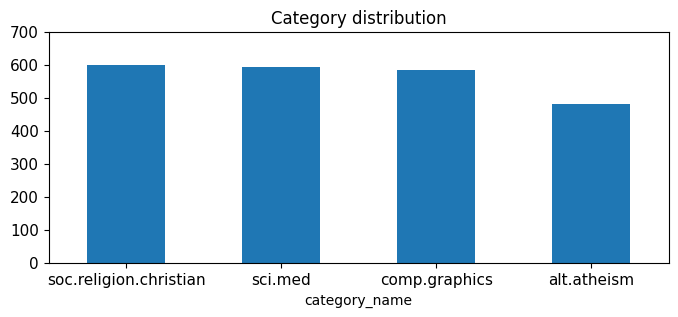

In [64]:
print(X.category_name.value_counts())

# plot barchart for X
X.category_name.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 700],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

category_name
soc.religion.christian    276
sci.med                   273
comp.graphics             245
alt.atheism               206
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='category_name'>

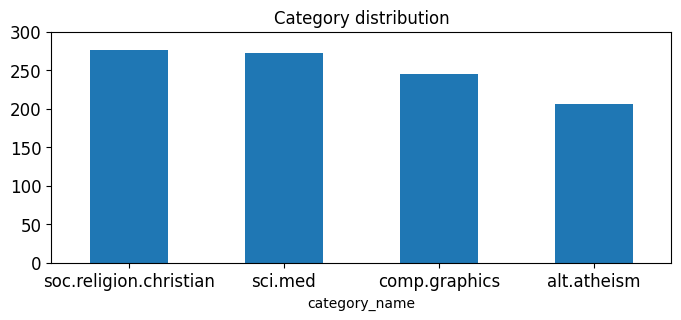

In [65]:
print(X_sample.category_name.value_counts())

# plot barchart for X_sample
X_sample.category_name.value_counts().plot(kind = 'bar',
                                           title = 'Category distribution',
                                           ylim = [0, 300], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

You can use following command to see other available styles to prettify your charts.
```python
print(plt.style.available)```

---

### >>> **Exercise 7 (Watch Video):**
Notice that for the `ylim` parameters we hardcoded the maximum value for y. Is it possible to automate this instead of hard-coding it? How would you go about doing that? (Hint: look at code above for clues)

category_name
soc.religion.christian    276
sci.med                   273
comp.graphics             245
alt.atheism               206
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='category_name'>

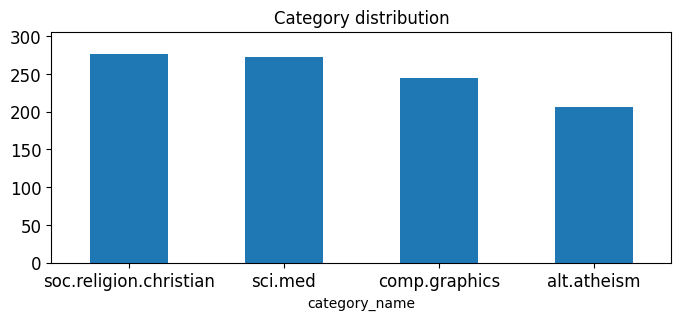

In [66]:
# Answer here
print(X_sample.category_name.value_counts())

# plot barchart for X_sample
X_sample.category_name.value_counts().plot(kind = 'bar',
                                           title = 'Category distribution',
                                           ylim = [0, X_sample.category_name.value_counts().max()+30], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

---

### >>> **Exercise 8 (take home):** 
We can also do a side-by-side comparison of the distribution between the two datasets, but maybe you can try that as an excerise. Below we show you an snapshot of the type of chart we are looking for. 

![alt txt](https://i.imgur.com/9eO431H.png)

<Axes: title={'center': 'Category distribution: X vs X_sample'}, xlabel='category_name'>

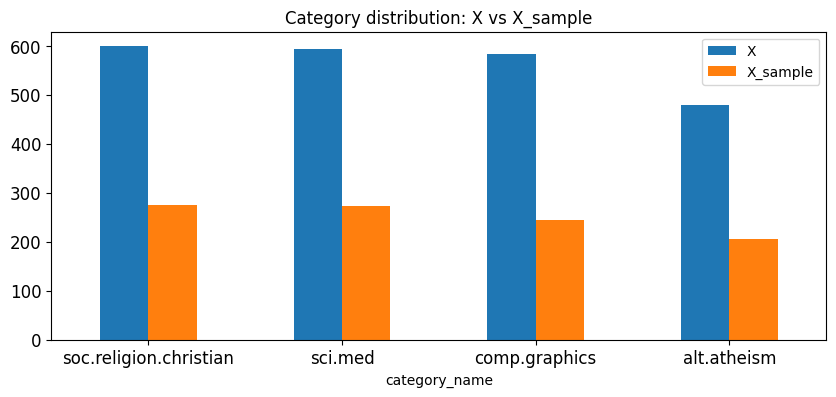

In [67]:
# Answer here
counts_df = pd.DataFrame({
    "X": X.category_name.value_counts(),
    "X_sample": X_sample.category_name.value_counts()
}).astype(int)
counts_df.plot(kind="bar",
               figsize=(10,4),
               rot=0,
               fontsize=12,
               title="Category distribution: X vs X_sample")

One thing that stood out from the both datasets, is that the distribution of the categories remain relatively the same, which is a good sign for us data scientist. There are many ways to conduct sampling on the dataset and still obtain a representative enough dataset. That is not the main focus in this notebook, but if you would like to know more about sampling and how the `sample` feature works, just reference the Pandas documentation and you will find interesting ways to conduct more advanced sampling.

---

### 5.2 Feature Creation
The other operation from the list above that we are going to practise on is the so-called feature creation. As the name suggests, in feature creation we are looking at creating new interesting and useful features from the original dataset; a feature which captures the most important information from the raw information we already have access to. In our `X` table, we would like to create some features from the `text` field, but we are still not sure what kind of features we want to create. We can think of an interesting problem we want to solve, or something we want to analyze from the data, or some questions we want to answer. This is one process to come up with features -- this process is usually called `feature engineering` in the data science community. 

We know what feature creation is so let us get real involved with our dataset and make it more interesting by adding some special features or attributes if you will. First, we are going to obtain the **unigrams** for each text. (Unigram is just a fancy word we use in Text Mining which stands for 'tokens' or 'individual words'.) Yes, we want to extract all the words found in each text and append it as a new feature to the pandas dataframe. The reason for extracting unigrams is not so clear yet, but we can start to think of obtaining some statistics about the articles we have: something like **word distribution** or **word frequency**.

Before going into any further coding, we will also introduce a useful text mining library called [NLTK](http://www.nltk.org/). The NLTK library is a natural language processing tool used for text mining tasks, so might as well we start to familiarize ourselves with it from now (It may come in handy for the final project!). In partcular, we are going to use the NLTK library to conduct tokenization because we are interested in splitting a sentence into its individual components, which we refer to as words, emojis, emails, etc. So let us go for it! We can call the `nltk` library as follows:

```python
import nltk
```

In [68]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\A2282\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\A2282\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [69]:
# takes a like a minute or two to process

X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

In [70]:
X[0:4]["unigrams"]

0    [From, :, sd345, @, city.ac.uk, (, Michael, Co...
1    [From, :, ani, @, ms.uky.edu, (, Aniruddha, B....
2    [From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...
3    [From, :, s0612596, @, let.rug.nl, (, M.M, ., ...
Name: unigrams, dtype: object

If you take a closer look at the `X` table now, you will see the new columns `unigrams` that we have added. You will notice that it contains an array of tokens, which were extracted from the original `text` field. At first glance, you will notice that the tokenizer is not doing a great job, let us take a closer at a single record and see what was the exact result of the tokenization using the `nltk` library.

In [71]:
X[0:4]

,text,category,category_name,unigrams
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics,"[From, :, sd345, @, city.ac.uk, (, Michael, Co..."
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics,"[From, :, ani, @, ms.uky.edu, (, Aniruddha, B...."
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian,"[From, :, djohnson, @, cs.ucsd.edu, (, Darin, ..."
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian,"[From, :, s0612596, @, let.rug.nl, (, M.M, ., ..."


In [72]:
list(X[0:1]['unigrams'])

[['From',
  ':',
  'sd345',
  '@',
  'city.ac.uk',
  '(',
  'Michael',
  'Collier',
  ')',
  'Subject',
  ':',
  'Converting',
  'images',
  'to',
  'HP',
  'LaserJet',
  'III',
  '?',
  'Nntp-Posting-Host',
  ':',
  'hampton',
  'Organization',
  ':',
  'The',
  'City',
  'University',
  'Lines',
  ':',
  '14',
  'Does',
  'anyone',
  'know',
  'of',
  'a',
  'good',
  'way',
  '(',
  'standard',
  'PC',
  'application/PD',
  'utility',
  ')',
  'to',
  'convert',
  'tif/img/tga',
  'files',
  'into',
  'LaserJet',
  'III',
  'format',
  '.',
  'We',
  'would',
  'also',
  'like',
  'to',
  'do',
  'the',
  'same',
  ',',
  'converting',
  'to',
  'HPGL',
  '(',
  'HP',
  'plotter',
  ')',
  'files',
  '.',
  'Please',
  'email',
  'any',
  'response',
  '.',
  'Is',
  'this',
  'the',
  'correct',
  'group',
  '?',
  'Thanks',
  'in',
  'advance',
  '.',
  'Michael',
  '.',
  '--',
  'Michael',
  'Collier',
  '(',
  'Programmer',
  ')',
  'The',
  'Computer',
  'Unit',
  ',',
  'Emai

The `nltk` library does a pretty decent job of tokenizing our text. There are many other tokenizers online, such as [spaCy](https://spacy.io/), and the built in libraries provided by [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). We are making use of the NLTK library because it is open source and because it does a good job of segmentating text-based data. 

---

### 5.3 Feature subset selection
Okay, so we are making some headway here. Let us now make things a bit more interesting. We are going to do something different from what we have been doing thus far. We are going use a bit of everything that we have learned so far. Briefly speaking, we are going to move away from our main dataset (one form of feature subset selection), and we are going to generate a document-term matrix from the original dataset. In other words we are going to be creating something like this. 

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vS01RrtPHS3r1Lf8UjX4POgDol-lVF4JAbjXM3SAOU-dOe-MqUdaEMWwJEPk9TtiUvcoSqTeE--lNep/pub?w=748&h=366)

Initially, it won't have the same shape as the table above, but we will get into that later. For now, let us use scikit learn built in functionalities to generate this document. You will see for yourself how easy it is to generate this table without much coding. 

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text) #learn the vocabulary and return document-term matrix
print(X_counts[0])

  (np.int32(0), np.int32(14887))	1
  (np.int32(0), np.int32(29022))	1
  (np.int32(0), np.int32(8696))	4
  (np.int32(0), np.int32(4017))	2
  (np.int32(0), np.int32(33256))	2
  (np.int32(0), np.int32(21661))	3
  (np.int32(0), np.int32(9031))	3
  (np.int32(0), np.int32(31077))	1
  (np.int32(0), np.int32(9805))	2
  (np.int32(0), np.int32(17366))	1
  (np.int32(0), np.int32(32493))	4
  (np.int32(0), np.int32(16916))	2
  (np.int32(0), np.int32(19780))	2
  (np.int32(0), np.int32(17302))	2
  (np.int32(0), np.int32(23122))	1
  (np.int32(0), np.int32(25663))	1
  (np.int32(0), np.int32(16881))	1
  (np.int32(0), np.int32(16082))	1
  (np.int32(0), np.int32(23915))	1
  (np.int32(0), np.int32(32142))	5
  (np.int32(0), np.int32(33597))	2
  (np.int32(0), np.int32(20253))	1
  (np.int32(0), np.int32(587))	1
  (np.int32(0), np.int32(12051))	1
  (np.int32(0), np.int32(5201))	1
  :	:
  (np.int32(0), np.int32(25361))	1
  (np.int32(0), np.int32(25337))	1
  (np.int32(0), np.int32(12833))	2
  (np.int32(0), np.in

Now you can also see some examples of what each feature is based on their index in the vector:

In [74]:
count_vect.get_feature_names_out()[14887]

'from'

In [75]:
count_vect.get_feature_names_out()[29022]

'sd345'

In [76]:
count_vect.get_feature_names_out()[8696]

'city'

In [77]:
count_vect.get_feature_names_out()[4017]

'ac'

What we did with those two lines of code is that we transformed the articles into a **term-document matrix**. Those lines of code tokenize each article using a built-in, default tokenizer (often referred to as an `analyzer`) and then produces the word frequency vector for each document. We can create our own analyzers or even use the nltk analyzer that we previously built. To keep things tidy and minimal we are going to use the default analyzer provided by `CountVectorizer`. Let us look closely at this analyzer. 

In [78]:
analyze = count_vect.build_analyzer()
analyze("I am craving for a hawaiian pizza right now")

# tokenization, remove stop words (e.g i, a, the), create n-gram (or unigram)

['am', 'craving', 'for', 'hawaiian', 'pizza', 'right', 'now']

---

### **>>> Exercise 9 (Watch Video):**
Let's analyze the first record of our X dataframe with the new analyzer we have just built. Go ahead try it!

In [79]:
# Answer here
# How do we turn our array[0] text document into a tokenized text using the build_analyzer()?
analyze(X['text'][0])

['from',
 'sd345',
 'city',
 'ac',
 'uk',
 'michael',
 'collier',
 'subject',
 'converting',
 'images',
 'to',
 'hp',
 'laserjet',
 'iii',
 'nntp',
 'posting',
 'host',
 'hampton',
 'organization',
 'the',
 'city',
 'university',
 'lines',
 '14',
 'does',
 'anyone',
 'know',
 'of',
 'good',
 'way',
 'standard',
 'pc',
 'application',
 'pd',
 'utility',
 'to',
 'convert',
 'tif',
 'img',
 'tga',
 'files',
 'into',
 'laserjet',
 'iii',
 'format',
 'we',
 'would',
 'also',
 'like',
 'to',
 'do',
 'the',
 'same',
 'converting',
 'to',
 'hpgl',
 'hp',
 'plotter',
 'files',
 'please',
 'email',
 'any',
 'response',
 'is',
 'this',
 'the',
 'correct',
 'group',
 'thanks',
 'in',
 'advance',
 'michael',
 'michael',
 'collier',
 'programmer',
 'the',
 'computer',
 'unit',
 'email',
 'collier',
 'uk',
 'ac',
 'city',
 'the',
 'city',
 'university',
 'tel',
 '071',
 '477',
 '8000',
 'x3769',
 'london',
 'fax',
 '071',
 '477',
 '8565',
 'ec1v',
 '0hb']

---

Now let us look at the term-document matrix we built above.

In [80]:
# We can check the shape of this matrix by:
X_counts.shape

(2257, 35788)

In [81]:
# We can obtain the feature names of the vectorizer, i.e., the terms
# usually on the horizontal axis
count_vect.get_feature_names_out()[0:10]

array(['00', '000', '0000', '0000001200', '000005102000', '0001',
       '000100255pixel', '00014', '000406', '0007'], dtype=object)

![alt txt](https://i.imgur.com/57gA1sd.png)

Above we can see the features found in the all the documents `X`, which are basically all the terms found in all the documents. As I said earlier, the transformation is not in the pretty format (table) we saw above -- the term-document matrix. We can do many things with the `count_vect` vectorizer and its transformation `X_counts`. You can find more information on other cool stuff you can do with the [CountVectorizer](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). 

Now let us try to obtain something that is as close to the pretty table I provided above. Before jumping into the code for doing just that, it is important to mention that the reason for choosing the `fit_transform` for the `CountVectorizer` is that it efficiently learns the vocabulary dictionary and returns a term-document matrix.

In the next bit of code, we want to extract the first five articles and transform them into document-term matrix, or in this case a 2-dimensional array. Here it goes. 

In [82]:
X_counts.shape

(2257, 35788)

In [83]:
# we convert from sparse array to normal array
X_counts[0:5, 0:100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [84]:
count_vect.get_feature_names_out()[0:1]

array(['00'], dtype=object)

As you can see the result is just this huge sparse matrix, which is computationally intensive to generate and difficult to visualize. But we can see that the fifth record, specifically, contains a `1` in the beginning, which from our feature names we can deduce that this article contains exactly one `00` term.

---

### **>>> Exercise 10 (take home):**
We said that the `1` at the beginning of the fifth record represents the `00` term. Notice that there is another 1 in the same record. Can you provide code that can verify what word this 1 represents from the vocabulary. Try to do this as efficient as possible.

In [85]:
# Answer here

count_vect.get_feature_names_out()[np.where(X_counts[4, 0:100].toarray()>0)[1][1]]

'01'

---

To get you started in thinking about how to better analyze your data or transformation, let us look at this nice little heat map of our term-document matrix. It may come as a surpise to see the gems you can mine when you start to look at the data from a different perspective. Visualization are good for this reason.

In [86]:
# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[0:20]]

In [87]:
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]

In [88]:
plot_z = X_counts[0:20, 0:20].toarray() #X_counts[how many documents, how many terms]
plot_z

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

For the heat map, we are going to use another visualization library called `seaborn`. It's built on top of matplotlib and closely integrated with pandas data structures. One of the biggest advantages of seaborn is that its default aesthetics are much more visually appealing than matplotlib. See comparison below.

![alt txt](https://i.imgur.com/1isxmIV.png)

The other big advantage of seaborn is that seaborn has some built-in plots that matplotlib does not support. Most of these can eventually be replicated by hacking away at matplotlib, but they’re not built in and require much more effort to build.

So without further ado, let us try it now!

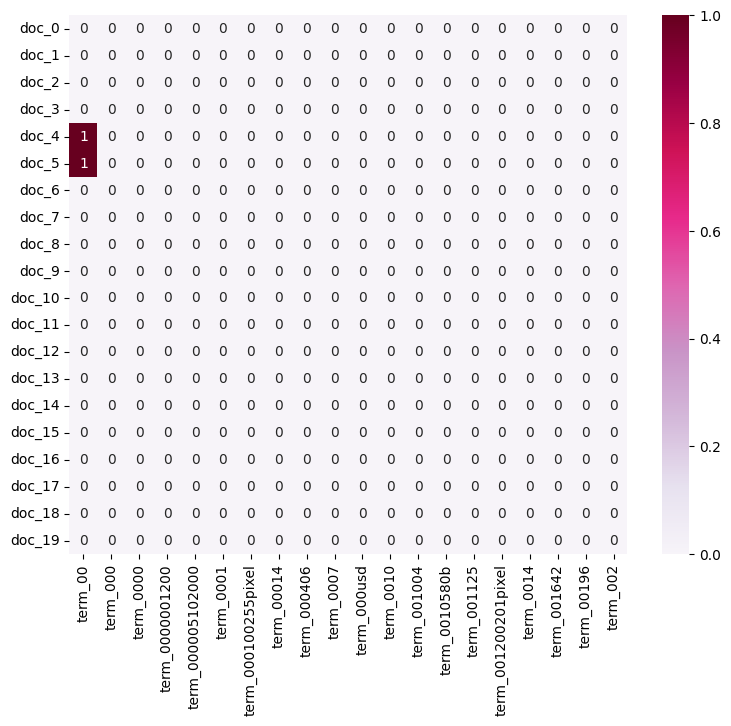

In [89]:
import seaborn as sns

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

Check out more beautiful color palettes here: https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/

---

### **>>> Exercise 11 (take home):** 
From the chart above, we can see how sparse the term-document matrix is; i.e., there is only one terms with **FREQUENCY** of `1` in the subselection of the matrix. By the way, you may have noticed that we only selected 20 articles and 20 terms to plot the histrogram. As an excersise you can try to modify the code above to plot the entire term-document matrix or just a sample of it. How would you do this efficiently? Remember there is a lot of words in the vocab. Report below what methods you would use to get a nice and useful visualization

I eliminated documents with less than 2000 words and terms that appear less than 500 times in the corpus.


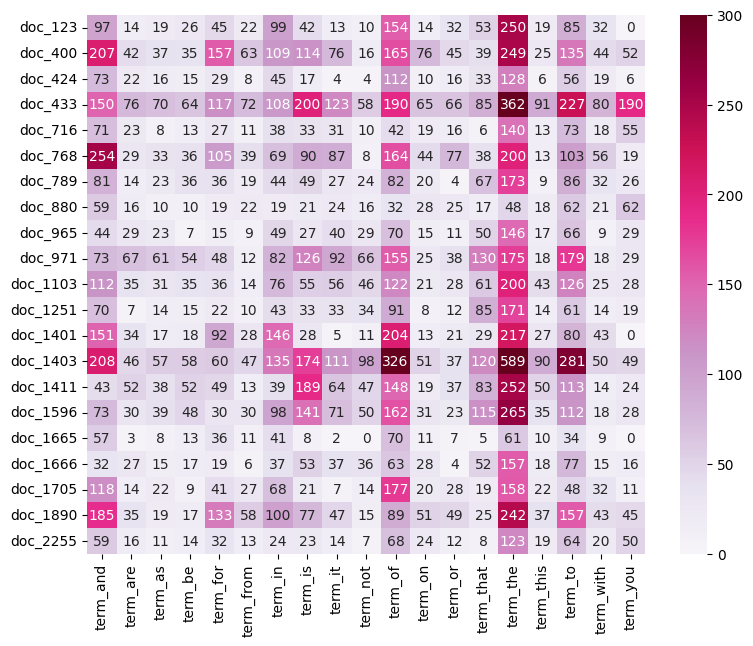

In [90]:
# Answer here
import numpy as np

print("I eliminated documents with less than 2000 words and terms that appear less than 500 times in the corpus.")
doc_lengths = np.array(X_counts.sum(axis=1)).ravel()
min_len = 2000
mask_docs = doc_lengths >= min_len
plot_z = X_counts[mask_docs, :]

term_freqs = np.array(plot_z.sum(axis=0)).ravel()
min_freq = 500
mask_terms = term_freqs >= min_freq
plot_z = plot_z[:, mask_terms].toarray()




# 過濾詞彙
terms = np.array(count_vect.get_feature_names_out())
terms = terms[mask_terms]  # 更新後的詞彙表
plot_x = ["term_"+str(i) for i in terms]
plot_y = ["doc_" + str(i) for i, keep in zip(X.index, mask_docs) if keep]
len(X.index) == len(mask_docs)
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
               cmap="PuRd",
               vmin=0, vmax=300, annot=True, fmt="d")


---

The great thing about what we have done so far is that we now open doors to new problems. Let us be optimistic. Even though we have the problem of sparsity and a very high dimensional data, we are now closer to uncovering wonders from the data. You see, the price you pay for the hard work is worth it because now you are gaining a lot of knowledge from what was just a list of what appeared to be irrelevant articles. Just the fact that you can blow up the data and find out interesting characteristics about the dataset in just a couple lines of code, is something that truly inspires me to practise Data Science. That's the motivation right there!

---

### 5.4 Attribute Transformation / Aggregation
We can do other things with the term-vector matrix besides applying dimensionality reduction technique to deal with sparsity problem. Here we are going to generate a simple distribution of the words found in all the entire set of articles. Intuitively, this may not make any sense, but in data science sometimes we take some things for granted, and we just have to explore the data first before making any premature conclusions. On the topic of attribute transformation, we will take the word distribution and put the distribution in a scale that makes it easy to analyze patterns in the distrubution of words. Let us get into it!

###  5.4.1 Transform Text Data

First, we need to compute these frequencies for each term in all documents. Visually speaking, we are seeking to add values of the 2D matrix, vertically; i.e., sum of each column. You can also refer to this process as aggregation, which we won't explore further in this notebook because of the type of data we are dealing with. But I believe you get the idea of what that includes.  

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vTMfs0zWsbeAl-wrpvyCcZqeEUf7ggoGkDubrxX5XtwC5iysHFukD6c-dtyybuHnYigiRWRlRk2S7gp/pub?w=750&h=412)

In [91]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
term_frequencies = []
for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))

#[3, 8, 5, 2, 5, 8, 2, 5, 3, 2]

In [92]:
term_frequencies = np.asarray(X_counts.sum(axis=0))[0]

In [93]:
term_frequencies[0] #sum of first term: 00

np.int64(134)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\3480579971.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);


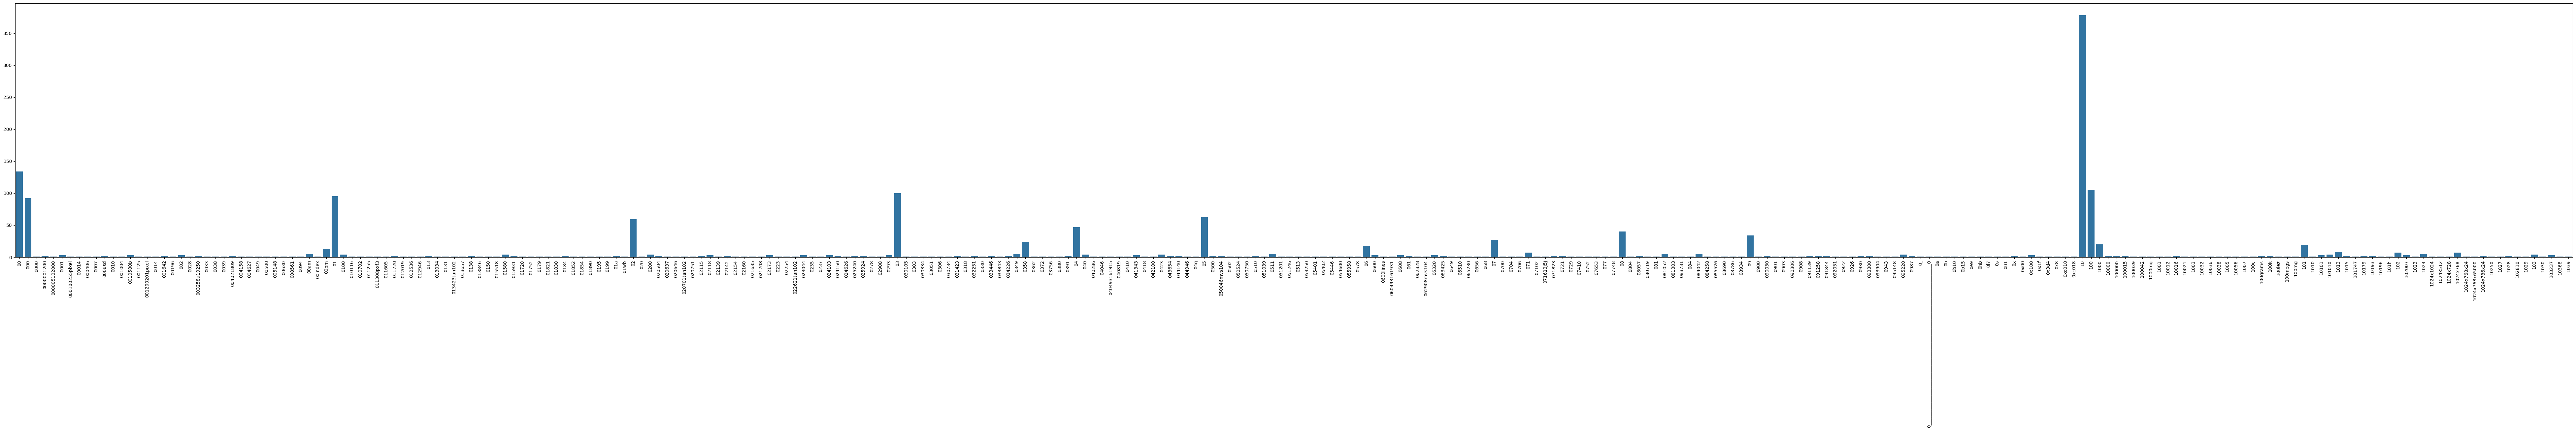

In [94]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

---

### >>> **Exercise 12 (take home):**
If you want a nicer interactive visualization here, I would encourage you try to install and use plotly to achieve this.

In [95]:
# Answer here
term_freqs = np.array(X_counts.sum(axis=0)).ravel()
min_freq = 100
mask_terms = term_freqs >= min_freq
terms = np.array(count_vect.get_feature_names_out())
terms = terms[mask_terms]
term_freq = np.asarray(X_counts.sum(axis=0))[0][np.where(mask_terms)[0]]
import plotly.express as px
import pandas as pd


df = pd.DataFrame({
    "Term": terms[0:300],         
    "Frequency": term_freq[0:300]
})


fig = px.bar(df, x="Term", y="Frequency",
             title="Terms Frequency",
             labels={"Term":"Word", "Frequency":"Count"},
             text="Frequency")  


fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=12,
    width=1200, height=600
)

fig.show()

---

### >>> **Exercise 13 (take home):** 
The chart above only contains 300 vocabulary in the documents, and it's already computationally intensive to both compute and visualize. Can you efficiently reduce the number of terms you want to visualize as an exercise. 


In [96]:
# Answer here
# Answer here
term_freqs = np.array(X_counts.sum(axis=0)).ravel()
min_freq = 2000
mask_terms = term_freqs >= min_freq
terms = np.array(count_vect.get_feature_names_out())
terms = terms[mask_terms]
term_freq = np.asarray(X_counts.sum(axis=0))[0][np.where(mask_terms)[0]]

#plt.subplots(figsize=(100, 50))
#g = sns.barplot(x=terms, 
#            y=term_frequencies[:300])
#g.set_xticklabels(terms, rotation = 90,fontsize=30);
import plotly.express as px
import pandas as pd


df = pd.DataFrame({
    "Term": terms,         
    "Frequency": term_freq
})


fig = px.bar(df, x="Term", y="Frequency",
             title="Terms Frequency",
             labels={"Term":"Word", "Frequency":"Count"},
             text="Frequency")  


fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=12,
    width=1200, height=600
)

fig.show()

---

### >>> **Exercise 14 (take home):** 
Additionally, you can attempt to sort the terms on the `x-axis` by frequency instead of in alphabetical order. This way the visualization is more meaninfgul and you will be able to observe the so called [long tail](https://en.wikipedia.org/wiki/Long_tail) (get familiar with this term since it will appear a lot in data mining and other statistics courses). see picture below

![alt txt](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Long_tail.svg/1000px-Long_tail.svg.png)

In [97]:
# Answer here
df = df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

fig = px.bar(df, x="Term", y="Frequency",
             title="Terms Frequency (Sorted by Frequency)",
             text="Frequency")

# 調整 x 軸標籤
fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=12,
    width=1200, height=600
)

fig.show()


---

Since we already have those term frequencies, we can also transform the values in that vector into the log distribution. All we need is to import the `math` library provided by python and apply it to the array of values of the term frequency vector. This is a typical example of attribute transformation. Let's go for it. The log distribution is a technique to visualize the term frequency into a scale that makes you easily visualize the distribution in a more readable format. In other words, the variations between the term frequencies are now easy to observe. Let us try it out!

In [98]:
import math
term_frequencies_log = [math.log(i) for i in term_frequencies]

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\2166548998.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



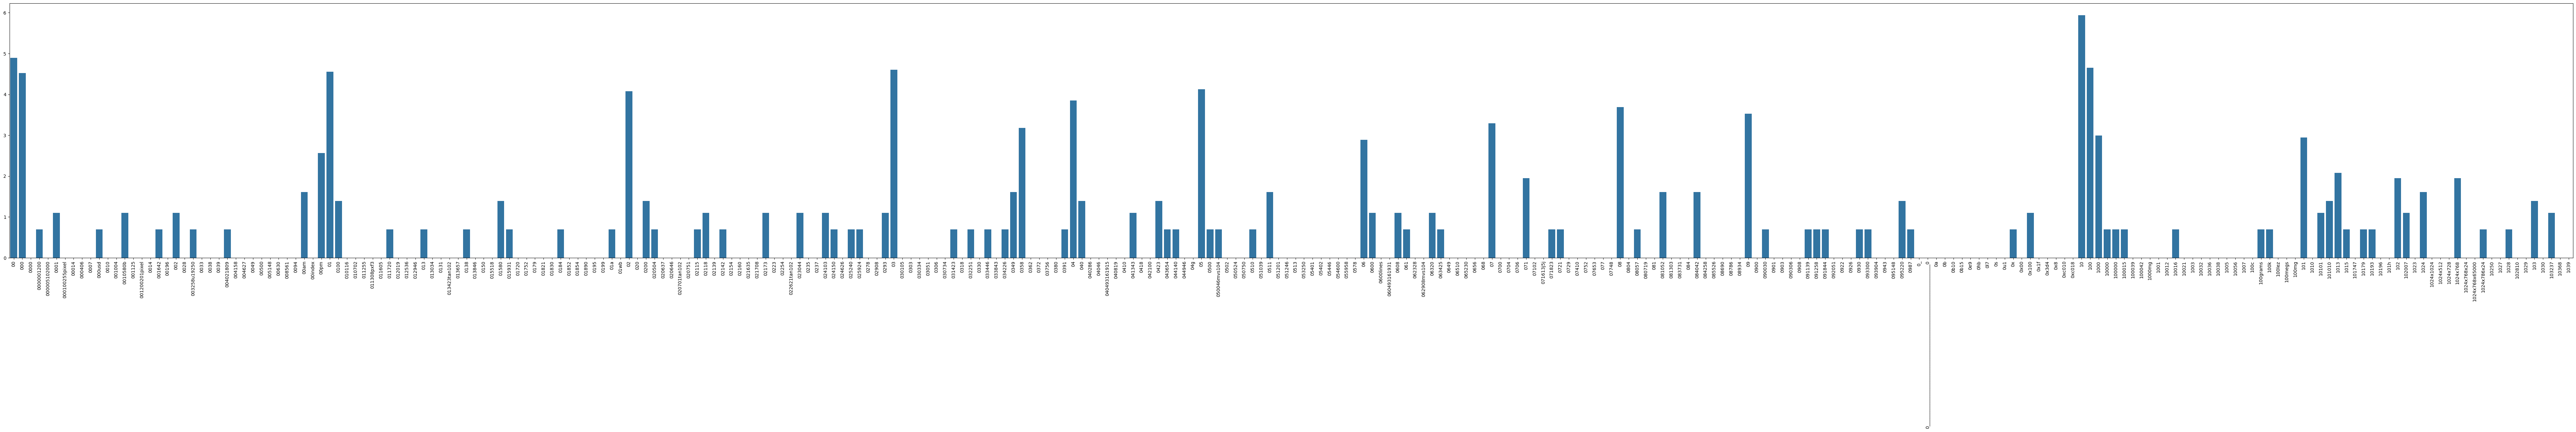

In [99]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

Besides observing a complete transformation on the disrtibution, notice the scale on the y-axis. The log distribution in our unsorted example has no meaning, but try to properly sort the terms by their frequency, and you will see an interesting effect. Go for it!

### >>> **Exercise 15 (take home):** 
You can copy the code from the previous exercise and change the 'term_frequencies' variable for the 'term_frequencies_log', comment about the differences that you observe and talk about other possible insights that we can get from a log distribution.

In [100]:
# Answer here
term_freqs = np.array(X_counts.sum(axis=0)).ravel()
min_freq = 2000
mask_terms = term_freqs >= min_freq
terms = np.array(count_vect.get_feature_names_out())
terms = terms[mask_terms]
term_freq = [f for f, keep in zip(term_frequencies_log, mask_terms) if keep]
df = pd.DataFrame({
    "Term": terms,         
    "Frequency": term_freq
})
df = df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

fig = px.bar(df, x="Term", y="Frequency",
             title="Terms Frequency (Sorted by Frequency)",
             text="Frequency")


fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=12,
    width=1200, height=600
)

fig.show()
#We can find that the logarithm smooths the differences between high and low frequencies.

End of Phase 1

The phase 1 exercises and homeworks should be committed and submitted before September 28th

---

### **Phase 2** 

###  5.4.2 Finding frequent patterns
Perfect, so now that we know how to interpret a document-term matrix from our text data, we will see how to get extra insight from it, we will do this by mining frequent patterns. For this we will be using the PAMI library that we previously installed.

**Introduction to PAMI**

PAMI (PAttern MIning) is a Python-based library designed to empower data scientists by providing the necessary tools to uncover hidden patterns within large datasets. Unlike other pattern mining libraries that are Java-based (such as WEKA and SPMF), PAMI caters specifically to the Python environment, making it more accessible for data scientists working with Big Data. The goal of PAMI is to streamline the process of discovering patterns that are often hidden within large datasets, offering a unified platform for applying various pattern mining techniques. In the library you can find a lot of implementations from current state-of-the-art algorithms, all of them cater to different type of data, they can be: transactional data, temporal data, utility data and some others. You can find more information in the following github: [PAMI](https://github.com/UdayLab/PAMI?tab=readme-ov-file). For the purpose of our lab we will be modeling our text data as a transactional type. So let's get into it.


<span style="color:red">Some code cells might have changed slightly from last year's explanation due to some updates of PAMI or fixes during the lab period of time</span>


**Transactional Data**

In order to apply pattern mining techniques, we first need to convert our text data into transactional data. A transactional database is a set of transactions where each transaction consists of a unique identifier (TID) and a set of items. For instance, think of a transaction as a basket of items purchased by a customer, and the TID is like the receipt number. Each transaction could contain items such as "apple", "banana", and "orange".

Here's an example of a transactional database:

TID	Transactions
1	a, b, c
2	d, e
3	a, e, f

In this structure:
TID refers to the unique identifier of each transaction (often ignored by PAMI to save storage space).
Items refer to the elements in each transaction, which could be either integers or strings (e.g., products, words, etc.).
When preparing text data, we need to transform sentences or documents into a similar format, where each sentence or document becomes a transaction, and the words within it become the items.

**Frequent Pattern Mining**

After converting the text into a transactional format, we can then apply frequent pattern mining. This process identifies patterns or combinations of items that occur frequently across the dataset. For example, in text data, frequent patterns might be common word pairs or phrases that appear together across multiple documents. Important term to learn: **Minimum Support**: It refers to the minimum frequency that a transaction has to have to be considered a pattern in our scenario.

PAMI allows us to mine various types of patterns, but for the purpuse of this lab we will explore the following types:


**Patterns Above Minimum Support:** These are all patterns that meet a specified minimum support threshold. The result set can be quite large as it includes all frequent patterns, making it ideal for comprehensive analysis but potentially complex.

**Maximal Frequent Patterns:** These are the largest frequent patterns that cannot be extended by adding more items without reducing their frequency below the minimum support threshold. The result set is smaller and more concise, as it only includes the largest patterns, reducing redundancy.

**Top-K Frequent Patterns:** These patterns represent the K most frequent patterns, regardless of the minimum support threshold. The result set is highly focused and concise, with a fixed number of patterns, making it ideal when prioritizing the most frequent patterns.

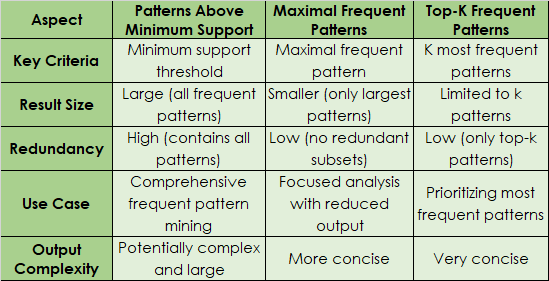

In the following steps, we will guide you through how to convert text data into transactional form and mine frequent patterns from it.


In our scenario, what we need is to mine patterns that can be representative to **each category**, in this way we will be able to differentiate each group of data more easily, for that we will need to first modify our document-term matrix to be able to work for each category, for this we will do the following:

In [101]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

#Create separate DataFrames for each category
categories = X['category_name'].unique()  # Get unique category labels
category_dfs = {}  # Dictionary to store DataFrames for each category

for category in categories:
    # Filter the original DataFrame by category
    category_dfs[category] = X[X['category_name'] == category].copy()

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    count_vect = CountVectorizer()  # Initialize the CountVectorizer
    X_counts = count_vect.fit_transform(df['text'])  # Transform the text data into word counts
    
    # Get the unique words (vocabulary) from the vectorizer
    words = count_vect.get_feature_names_out()
    
    # Create a DataFrame where rows are documents and columns are words
    term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)
    
    return term_document_df

# Create term-document frequency DataFrames for each category
filt_term_document_dfs = {}  # Dictionary to store term-document DataFrames for each category

for category in categories:
    filt_term_document_dfs[category] = create_term_document_df(category_dfs[category])

In [102]:
# Display the filtered DataFrame for one of the categories, feel free to change the number in the vector
category_number=0 #You can change it from 0 to 3
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filt_term_document_dfs[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category comp.graphics:


,00,000,000005102000,000100255pixel,0007,000usd,0010580b,001200201pixel,00196,002,...,zorn,zrz,zsoft,zt,zug,zurich,zvi,zyeh,zyxel,ªl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can see the number of unique words per category based on the column number in the new dataframe, feel free to **explore the changes of each category changing the vector number at the end**.

In the past sections we saw the behaviour of each word frequency in the documents, but we still want to generalize a little bit more so we can observe and determine the data that we are going to use to mine the patterns. For this we will group the terms in bins and we are going to plot their frequency. Again, feel free to change the category number to explore the different results.

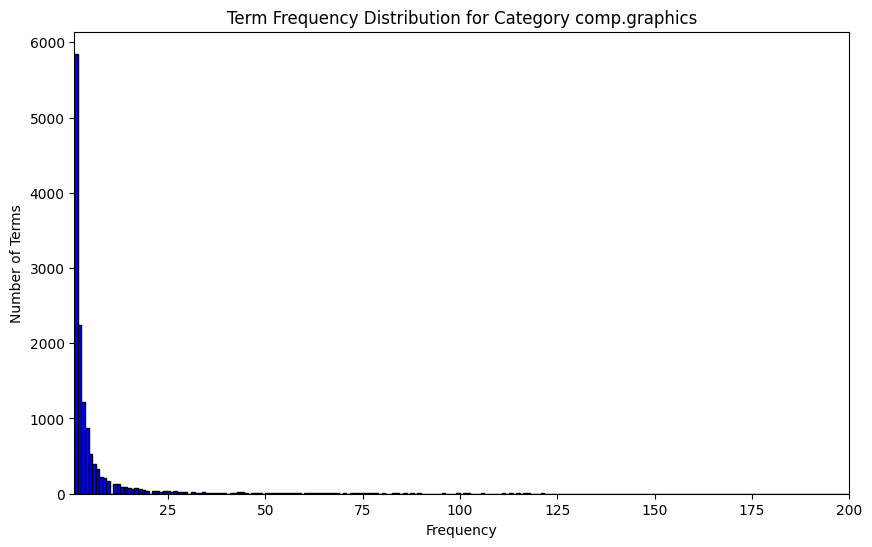

In [103]:
 # Sum over all documents to get total frequency for each word
category_number=0 #You can change it from 0 to 3
word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()
 
# Visualize the frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=5000, color='blue', edgecolor='black')
plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.xlim(1, 200)
plt.show()

From this graph, we can see that most of the words appear very infrequently across the entire dataset, while a small number of words appear quite often. When we're trying to find patterns in text data, we focus on combinations of words that are most helpful for classifying the documents. However, very rare words or extremely common words (like stopwords: 'the,' 'in,' 'a,' 'of,' etc.) don’t usually give us much useful information. To improve our results, we can filter out these words. Specifically, we'll remove the **bottom 1%** of the least frequent words and the **top 5%** of the most frequent ones. This helps us focus on words that might reveal more valuable patterns.

In this case, the choice of filtering the top 5% and bottom 1% is **arbitrary**, but in other applications, domain knowledge might guide us to filter words differently, depending on the type of text classification we're working on.

Let us look first at the words that we will be filtering based on the set percentage threshold.

In [104]:
category_number=0 #You can change it from 0 to 3
word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

# Sort the term frequencies in descending order
sorted_indices = np.argsort(word_counts)[::-1]  # Get indices of sorted frequencies
sorted_counts = np.sort(word_counts)[::-1]  # Sort frequencies in descending order

# Calculate the index corresponding to the top 5% most frequent terms
total_terms = len(sorted_counts)
top_5_percent_index = int(0.05 * total_terms)

# Get the indices of the top 5% most frequent terms
top_5_percent_indices = sorted_indices[:top_5_percent_index]

# Filter terms that belong to the top 5% based on their rank
filtered_words = [filt_term_document_dfs[categories[category_number]].iloc[:, i].name for i in top_5_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in top 5%: {top_5_percent_index}")
print(f"Filtered terms: {filtered_words}")



Category: comp.graphics
Number of terms in top 5%: 687
Filtered terms: ['the', 'to', 'of', 'and', 'is', 'in', 'for', 'it', 'from', 'you', 'edu', 'that', 'on', 'this', 'or', 'be', 'with', 'have', 'lines', 'can', 'subject', 'are', 'graphics', 'if', 'organization', 'image', 'as', 'not', 'but', 'at', 'there', 'com', 'an', 'any', 'will', 'by', 'university', 're', 'about', 'some', 'posting', 'file', 'do', 'would', 'all', 'host', 'jpeg', 'what', 'so', 'has', 'nntp', 'files', 'which', 'one', 'also', 'me', 'use', 'software', 'was', 'images', 'my', 'writes', 'other', 'article', 'out', 'data', 'program', 'know', 'like', 'version', 'more', 'color', 'ftp', 'your', 'get', 'computer', 'don', '3d', 'does', 'no', 'mail', 'format', 'they', 'available', 'need', 'we', 'ca', 'thanks', 'just', 'bit', 'gif', 'how', 'help', 'am', 'please', 'package', 'pub', 'anyone', 'very', 'information', 'using', 'code', 'than', 'line', 'system', 'find', 'only', 'time', 'where', '24', 'windows', 'good', 'cs', 'uk', 'display

Here we can explore the frequencies of the **top 5%** words:

In [105]:
sorted_counts #We can see the frequencies sorted in a descending order

array([4537, 2775, 2470, ...,    1,    1,    1])

In [106]:
sorted_indices #This are the indices corresponding to the words after being sorted in a descending order

array([12266, 12390,  9021, ...,    10,    11,    12])

In [107]:
filt_term_document_dfs[categories[category_number]].loc[:,'the'].sum(axis=0) #Here we can sum up the column corresponding to the top 5% words, we just specify which one first.

np.int64(4537)

In [108]:
category_number=0 #You can change it from 0 to 3
word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

# Sort the term frequencies in ascending order and get sorted indices
sorted_indices = np.argsort(word_counts)  # Get indices of sorted frequencies
sorted_counts = word_counts[sorted_indices]  # Sort frequencies

# Calculate the index corresponding to the bottom 1% least frequent terms
total_terms = len(sorted_counts)
bottom_1_percent_index = int(0.01 * total_terms)

# Get the indices of the bottom 1% least frequent terms
bottom_1_percent_indices = sorted_indices[:bottom_1_percent_index]

# Filter terms that belong to the bottom 1% based on their rank
filtered_words = [filt_term_document_dfs[categories[category_number]].iloc[:, i].name for i in bottom_1_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in bottom 1%: {bottom_1_percent_index}")
print(f"Filtered terms: {filtered_words}")


Category: comp.graphics
Number of terms in bottom 1%: 137
Filtered terms: ['0039', '0038', '0028', '00196', '001200201pixel', 'zillions', 'ziedman', 'zero_', '0199', '01890', '01854', '01852', '01821', '0179', '01752', '0150', 'zen', 'zeit', '02139', '020751', '020637', '020', 'zool', 'zoo', 'zirkel', 'zipped', '013846', 'zvi', '011605', '0100', 'ªl', '0049', '051201', '04g', '044946', '0410', '040819', '040493161915', '040286', 'zcat', 'zc', 'zbuffering', 'zaphod', 'zamenhof', 'z_c', 'yyqi', 'yy', 'yutani', '07653', '07410', '0729', '0704', '068', '0649', '060493161931', 'yr', 'youve', 'yourdon', 'yost', '0600', '054600', '05446', '05402', '053250', '0901', '0900', '08934', '08786', 'yktvmh', 'yk4', 'yingyong', 'yields', 'yielded', 'yield', 'yhe', 'yevtechenko', 'yevgeny', '083731', '080719', '077', '1001', '0xc018', '0xc010', '0x3d4', '0x1f', '0x00', '0hb', '0e9', '0b', '0a', '0______________________________________________________________________0', '0_', '0943', '0926', '092051', '

Here we can explore the frequencies of the **bottom 1%** words:

In [109]:
sorted_counts #We can see the frequencies sorted in an ascending order

array([   1,    1,    1, ..., 2470, 2775, 4537])

In [110]:
sorted_indices #This are the indices corresponding to the words after being sorted in an ascending order

array([   12,    11,    10, ...,  9021, 12390, 12266])

In [111]:
filt_term_document_dfs[categories[category_number]].loc[:,'l14h11'].sum(axis=0) #Here we can sum up the column corresponding to the bottom 1% words, we just specify which one first.

np.int64(1)

Well done, now that we have seen what type of words are inside the thresholds we set, then we can procede to **filter them out of the dataframe**. If you want to experiment after you complete the lab, you can return to try different percentages to filter, or not filter at all to do all the subsequent tasks for the pattern minings, and see if there is a significant change in the result.

In [112]:
category_number=0 #You can change it from 0 to 3

# Filter the bottom 1% and top 5% words based on their sum across all documents
def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    # Calculate the sum of each word across all documents
    word_sums = term_document_df.sum(axis=0)
    
    # Sort the words by their total sum
    sorted_words = word_sums.sort_values()
    
    # Calculate the number of words to remove
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    # Get the words to remove from the top 5% and bottom 1%
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    print(f'Bottom {bottom_percent*100}% words: \n{sorted_words.head(bottom_n)}') #Here we print which words correspond to the bottom percentage we filter
    print(f'Top {top_percent*100}% words: \n{sorted_words.tail(top_n)}') #Here we print which words correspond to the top percentage we filter
    # Return the DataFrame without the filtered words
    return term_document_df.drop(columns=words_to_remove)

# Apply the filtering function to each category
term_document_dfs = {}

for category in categories:
    print(f'\nFor category {category} we filter the following words:')
    term_document_dfs[category] = filter_top_bottom_words_by_sum(filt_term_document_dfs[category])

# Example: Display the filtered DataFrame for one of the categories
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
term_document_dfs[categories[category_number]]



For category comp.graphics we filter the following words:
Bottom 1.0% words: 
0039              1
0038              1
0028              1
00196             1
001200201pixel    1
                 ..
10fps             1
10665             1
1066              1
xwindow           1
xwdtopnm          1
Length: 137, dtype: int64
Top 5.0% words: 
further      27
ii           27
27           27
martin       27
multi        27
           ... 
is         1751
and        2382
of         2470
to         2775
the        4537
Length: 687, dtype: int64

For category soc.religion.christian we filter the following words:
Bottom 1.0% words: 
0706           1
zeitschrift    1
zeal           1
zara           1
yves           1
              ..
prevented__    1
prevented      1
prevelant      1
preeminence    1
predicts       1
Length: 138, dtype: int64
Top 5.0% words: 
pagan         36
mmalt         36
reject        36
friend        36
parents       37
           ...  
that        4393
and         4409
to

,000,000005102000,000100255pixel,0007,000usd,0010580b,002,0094,00index,00pm,...,zopfi,zorg,zorn,zrz,zsoft,zt,zug,zurich,zyeh,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### >>> **Exercise 16 (take home):** 
Review the words that were filtered in each category and comment about the differences and similarities that you can see.

In [113]:
# Answer here
# Review the words that were filtered in each category and comment about the differences and similarities that you can see.
print("for each category we can see that the filtered words are different, but some of them are similar. \nFor example, in the bottom 1% we can see that there are some words that are not common in the English language, such as  'xwdtopnm', 'xwindow', etc. \nThese words are not common in the English language and they are not useful for our analysis. In the top 5% we can see that there are some common words in the English language, such as 'the', 'and', 'is', etc. \nThese words are common in the English language and they are not useful for our analysis.")

for each category we can see that the filtered words are different, but some of them are similar. 
For example, in the bottom 1% we can see that there are some words that are not common in the English language, such as  'xwdtopnm', 'xwindow', etc. 
These words are not common in the English language and they are not useful for our analysis. In the top 5% we can see that there are some common words in the English language, such as 'the', 'and', 'is', etc. 
These words are common in the English language and they are not useful for our analysis.


Great! Now that our document-term frequency dataframe is ready, we can proceed with the frequent pattern mining process. To do this, we first need to convert our dataframe into a transactional database that the PAMI library can work with. We will generate a CSV file for each category to create this database.

A key step in this process is defining the threshold that determines when a value in the data is considered a transaction. As we observed in the previous cell, there are **many zeros** in our dataframe, which indicate that certain words do not appear in specific documents. With this in mind, we'll set the transactional threshold to be **greater than or equal to 1**. This means that for each document/transaction, we will include all the words that occur at least once (after filtering), ensuring that only relevant words are included in the pattern mining process. For your reference you can also check the following real world example that the PAMI library provides to review how they chose the threshold to generate the transactional data: [Air Pollution Analytics - Japan](https://colab.research.google.com/github/udayLab/PAMI/blob/main/notebooks/airPollutionAnalytics.ipynb). 

#### The next part of the code will take a couple of minutes to execute, for simplicity I already shared the resulting files from it, to continue onwards

#### Given that some students have been experiencing some errors with recent newer versions of PAMI after Oct 11, where they changed some directories of these functions, you can try to run the following block of code or uncomment the lines indicated inside to run the older version of the functions:

In [114]:
# from PAMI.extras.convert.DF2DB import DF2DB            

# # Loop through the dictionary of term-document DataFrames
# for category in term_document_dfs:
#     # Replace dots with underscores in the category name to avoid errors in the file creation
#     category_safe = category.replace('.', '_')
    
#     # Create the DenseFormatDF object and convert to a transactional database
#     obj = DF2DB(term_document_dfs[category])           
        
#     obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}.csv', '>=', 1)


<span style="color:red">If you encounter errors when running the above codes, try commenting out the above codes and running the code in this box. This error may comes from the update of the source code from the PAMI library. </span>

```python
from PAMI.extras.DF2DB import DenseFormatDF as db              

# Loop through the dictionary of term-document DataFrames
for category in term_document_dfs:
    # Replace dots with underscores in the category name to avoid errors in the file creation
    category_safe = category.replace('.', '_')
    
    # Create the DenseFormatDF object and convert to a transactional database
    obj = db.DenseFormatDF(term_document_dfs[category]) 
                                                                
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}.csv', '>=', 1)
```
---

Now let us look into the stats of our newly created transactional databases, we will observe the following:

- **Database Size (Total Number of Transactions)**: Total count of transactions in the dataset.

- **Number of Items**: Total count of unique items available across all transactions.

- **Minimum Transaction Size**: Smallest number of items in any transaction, indicating the simplest transaction.

- **Average Transaction Size**: Mean number of items per transaction, showing the typical complexity.

- **Maximum Transaction Size**: Largest number of items in a transaction, representing the most complex scenario.

- **Standard Deviation of Transaction Size**: Measures variability in transaction sizes; higher values indicate greater diversity.

- **Variance in Transaction Sizes**: Square of the standard deviation, providing a broader view of transaction size spread.

- **Sparsity**: Indicates the proportion of possible item combinations that do not occur, with values close to 1 showing high levels of missing combinations.

With regards to the graphs we will have: 

- **Item Frequency Distribution**
    - Y-axis (Frequency): Number of transactions an item appears in.
    - X-axis (Number of Items): Items ranked by frequency.

- **Transaction Length Distribution**
    - Y-axis (Frequency): Occurrence of transaction lengths.
    - X-axis (Transaction Length): Number of items per transaction.

<span style="color:red">If you encounter errors when running the subsequent codes due to UTF-8 encoding, try running the codes in this box first</span>

```python
import builtins

_orig_open = open

def safe_open(*args, **kwargs):
    if len(args) > 0 and isinstance(args[0], str) and args[0].endswith('.csv'):
        kwargs['encoding'] = 'latin-1'   # Force Latin-1
        kwargs['errors'] = 'ignore'      # Ignore bad characters
    return _orig_open(*args, **kwargs)


builtins.open = safe_open
```
---

Database size (total no of transactions) : 584
Number of items : 12932
Minimum Transaction Size : 4
Average Transaction Size : 56.41609589041096
Maximum Transaction Size : 2061
Standard Deviation Transaction Size : 152.701494376309
Variance in Transaction Sizes : 23357.742519208627
Sparsity : 0.9956374809858946


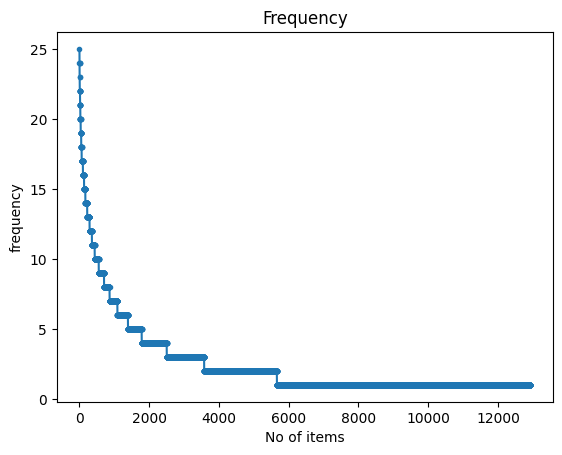

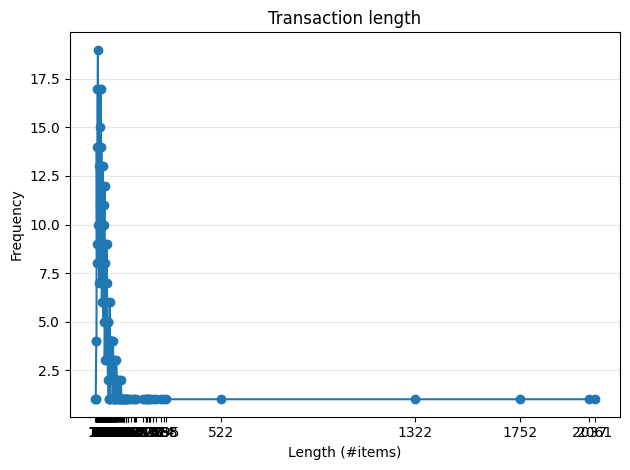

In [115]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_comp_graphics.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

<span style="color:red">If you see that in the graph the numbers are sticked together (unlike what you see in the tutorial video) it is normal. This may be due to the update of the PAMI library. Our TA have reported the issue to the PAMI developers, if there are any update that fixes this issue we will let you know of it during the period of time of this lab.</span>

Database size (total no of transactions) : 594
Number of items : 15283
Minimum Transaction Size : 9
Average Transaction Size : 74.51515151515152
Maximum Transaction Size : 1069
Standard Deviation Transaction Size : 115.25322993083026
Variance in Transaction Sizes : 13305.707189943278
Sparsity : 0.9951243112271706


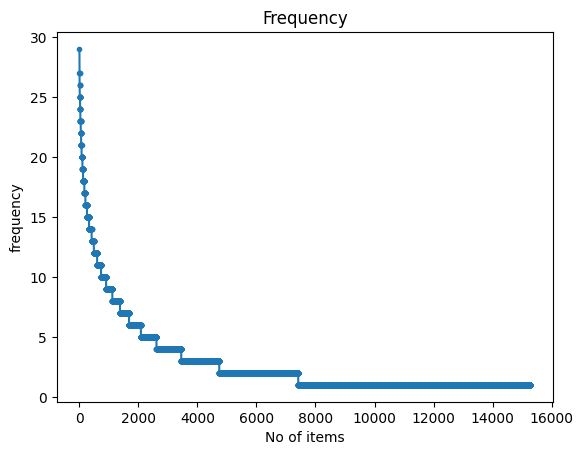

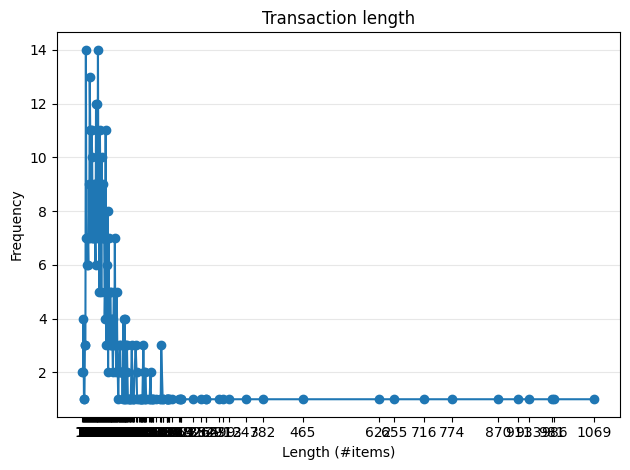

In [116]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_sci_med.csv')
obj.run()
obj.printStats()
obj.plotGraphs()


Database size (total no of transactions) : 599
Number of items : 13041
Minimum Transaction Size : 2
Average Transaction Size : 77.06176961602671
Maximum Transaction Size : 460
Standard Deviation Transaction Size : 62.48748408269708
Variance in Transaction Sizes : 3911.215241679276
Sparsity : 0.9940908082496721


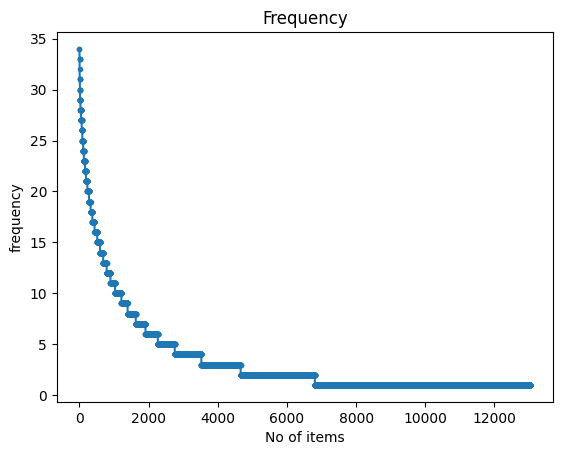

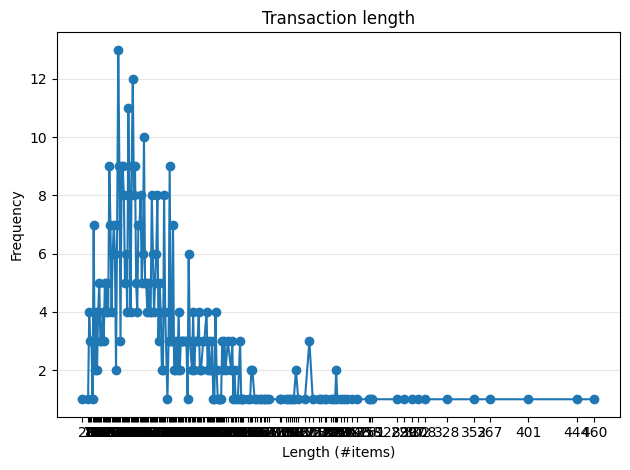

In [117]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_soc_religion_christian.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 480
Number of items : 11250
Minimum Transaction Size : 5
Average Transaction Size : 75.56458333333333
Maximum Transaction Size : 1404
Standard Deviation Transaction Size : 105.7264551992218
Variance in Transaction Sizes : 11201.41961986778
Sparsity : 0.9932831481481481


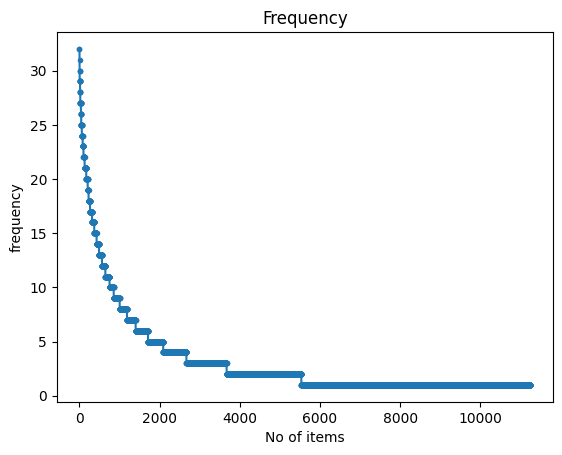

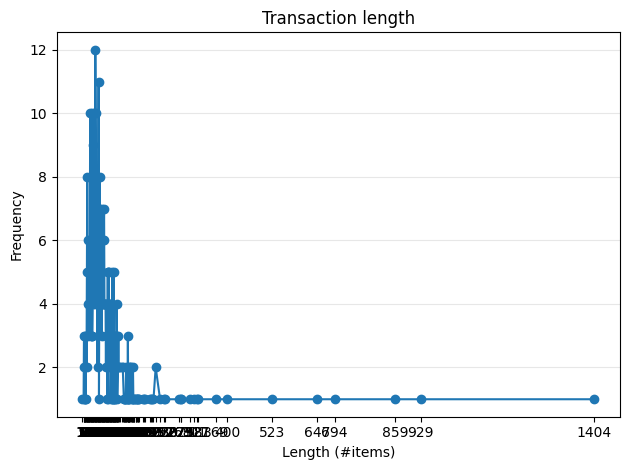

In [118]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_alt_atheism.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Now that we have reviewed the stats of our databases, there are some things to notice from them, the total number of transactions refer to the amount of documents per category, the number of items refer to the amount of unique words encountered in each category, the transaction size refers to the amount of words per document that it can be found, and we can see that our databases are very sparse, this is the result of having many zeros in the first place when making the document-term matrix. 

Why are these stats important? It is because we are going to use the FPGrowth algorithm from PAMI, and for that we need to determine the *minimum support* (frequency) that our algorithm will use to mine for patterns in our transactions. 

When we set a minimum support threshold (minSup) for finding frequent patterns, we are looking for a good balance. We want to capture important patterns that show real connections in the data, but we also want to avoid too many unimportant patterns. For this dataset, we've chosen a minSup of 9. We have done this after observing the following:

- **Item Frequency**: The first graph shows that most items don't appear very often in transactions. There's a sharp drop in how frequently items appear, which means our data has many items that aren't used much.

- **Transaction Length**: The second graph shows that most transactions involve a small number of items. The most common transaction sizes are small, which matches our finding that the dataset does not group many items together often.

By setting minSup at 9, we focus on combinations of items that show up in these smaller, more common transactions. This level is low enough to include items that show up more than just a few times, but it's high enough to leave out patterns that don't appear often enough to be meaningful. This helps us keep our results clear and makes sure the patterns we find are useful and represent what's really happening in the dataset. 

**This value works for all categories**. Now let's get into mining those patterns. For more information you can visit the FPGrowth example in PAMI for transactional data: [FPGrowth Example](https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/frequentPattern/basic/FPGrowth.ipynb#scrollTo=pLV84IYcDHe3).

In [119]:
from PAMI.frequentPattern.basic import FPGrowth as alg
minSup=9
obj1 = alg.FPGrowth(iFile='td_freq_db_sci_med.csv', minSup=minSup)
obj1.mine()
frequentPatternsDF_sci_med= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_sci_med))) #print the total number of patterns
print('Runtime: ' + str(obj1.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 9994
Runtime: 0.08454179763793945


In [120]:
obj1.save('freq_patterns_sci_med_minSup9.txt') #save the patterns
frequentPatternsDF_sci_med

,Patterns,Support
0,leave,9
1,swell,9
2,color,9
3,confused,9
4,learning,9
...,...,...
9989,1993apr15,26
9990,means,27
9991,happen,27
9992,originator,27


In [121]:
from PAMI.frequentPattern.basic import FPGrowth as alg
minSup=9
obj2 = alg.FPGrowth(iFile='td_freq_db_alt_atheism.csv', minSup=minSup)
obj2.mine()
frequentPatternsDF_alt_atheism= obj2.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_alt_atheism))) #print the total number of patterns
print('Runtime: ' + str(obj2.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 4628
Runtime: 0.08802294731140137


In [122]:
obj2.save('freq_patterns_alt_atheism_minSup9.txt') #save the patterns
frequentPatternsDF_alt_atheism

,Patterns,Support
0,choices,9
1,corp,9
2,hausmann,9
3,hausmann\tmaddi,9
4,kids,9
...,...,...
4623,comes,30
4624,getting,30
4625,date,31
4626,stay,32


In [123]:
from PAMI.frequentPattern.basic import FPGrowth as alg
minSup=9
obj3 = alg.FPGrowth(iFile='td_freq_db_comp_graphics.csv', minSup=minSup)
obj3.mine()
frequentPatternsDF_comp_graphics= obj3.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_comp_graphics))) #print the total number of patterns
print('Runtime: ' + str(obj3.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 33574
Runtime: 0.05818653106689453


In [124]:
obj3.save('freq_patterns_comp_graphics_minSup9.txt') #save the patterns
frequentPatternsDF_comp_graphics

,Patterns,Support
0,individual,9
1,certain,9
2,hall,9
3,mike,9
4,vr,9
...,...,...
33569,life,24
33570,ideas,24
33571,feel,24
33572,tried,24


In [125]:
from PAMI.frequentPattern.basic import FPGrowth as alg
minSup=9
obj4 = alg.FPGrowth(iFile='td_freq_db_soc_religion_christian.csv', minSup=minSup)
obj4.mine()
frequentPatternsDF_soc_religion_christian= obj4.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_soc_religion_christian))) #print the total number of patterns
print('Runtime: ' + str(obj4.getRuntime())) #measure the runtime

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 11213
Runtime: 0.27591490745544434


In [126]:
obj4.save('freq_patterns_soc_religion_minSup9.txt') #save the patterns
frequentPatternsDF_soc_religion_christian

,Patterns,Support
0,latest,9
1,san,9
2,seven,9
3,schools,9
4,chose,9
...,...,...
11208,34,33
11209,institute,33
11210,ways,33
11211,oh,34


Now that we've extracted the transactional patterns from our databases, the next step is to integrate them effectively with our initial data for further analysis. One effective method is to identify and use only the unique patterns that are specific to each category. This involves filtering out any patterns that are common across multiple categories.

The reason for focusing on **unique patterns** is that they can **significantly improve the classification process**. When a document contains these distinctive patterns, it provides clear, category-specific signals that help our model more accurately determine the document's category. This approach ensures that the patterns we use enhance the model's ability to distinguish between different types of content.

In [127]:
import pandas as pd

#We group together all of the dataframes related to our found patterns
dfs = [frequentPatternsDF_sci_med, frequentPatternsDF_soc_religion_christian, frequentPatternsDF_comp_graphics, frequentPatternsDF_alt_atheism]


# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
# Calculate the total number of patterns across all categories
total_patterns_count = sum(len(df) for df in dfs)
# Calculate how many patterns were discarded
discarded_patterns_count = total_patterns_count - len(unique_patterns)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

# Sort by support
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)
# Print the number of discarded patterns
print(f"Number of patterns discarded: {discarded_patterns_count}")

                   Patterns  Support
19908                   gov       33
19909             institute       33
57110               snm6394       32
19906                  form       31
19907                claims       31
...                     ...      ...
14     newsreader\tpl8\ttin        9
13                 pl8\ttin        9
12          pl8\tnewsreader        9
11                  holland        9
10                   deeply        9

[57111 rows x 2 columns]
Number of patterns discarded: 2298


We observed a significant number of patterns that were common across different categories, which is why we chose to discard them. The next step is to integrate these now category-specific patterns into our data. How will we do this? By converting the patterns into binary data within the columns of our document-term matrix. Specifically, we will check each document for the presence of each pattern. If a pattern is found in the document, we'll mark it with a '1'; if it's not present, we'll mark it with a '0'. This binary encoding allows us to effectively augment our data, enhancing its utility for subsequent classification tasks.

In [128]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Convert 'text' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
X_tdm = count_vect.fit_transform(X['text'])  # X['text'] contains your text data
terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary

# Tokenize the sentences into sets of unique words
X['tokenized_text'] = X['text'].str.split().apply(set)

# Initialize the pattern matrix
pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])

# Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    pattern_matrix[pattern] = X['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)

# Concatenate the original TDM and the pattern matrix to augment the features
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

augmented_df


,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,192\tinternational,means\t192\tcommunications,192\tcommunications,192\tmeans,quackery,newsreader\tpl8\ttin,pl8\ttin,pl8\tnewsreader,holland,deeply
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### >>> **Exercise 17 (take home):** 
Implement the FAE Top-K and MaxFPGrowth algorithms from the PAMI library to analyze the 'comp.graphics' category in our processed database. **Only implement the mining part of the algorithm and display the resulting patterns**, like we did with the FPGrowth algorithm after creating the new databases. For the FAE Top-K, run trials with k values of 500, 1000, and 1500, recording the runtime for each. For MaxFPGrowth, test minimum support thresholds of 3, 6, and 9, noting the runtime for these settings as well. Compare the patterns these algorithms extract with those from the previously implemented FPGrowth algorithm. Document your findings, focusing on differences and similarities in the outputs and performance. For this you can find the following google collabs for reference provided by their github repository here: [FAE Top-K](https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/frequentPattern/topk/FAE.ipynb) and [MaxFPGrowth](https://colab.research.google.com/github/UdayLab/PAMI/blob/main/notebooks/frequentPattern/maximal/MaxFPGrowth.ipynb)

In [129]:
# Answer Here
from PAMI.frequentPattern.topk import FAE as alg1
from PAMI.frequentPattern.maximal import MaxFPGrowth  as alg2
file_name = 'td_freq_db_comp_graphics.csv'
minSup = [3,6,9]
count_list = [500,1000,1500]

result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime'])
for count in count_list:
    obj = alg1.FAE(file_name, k = count)
    obj.mine()
    print(f'k={count}')
    #print(obj.getPatternsAsDataFrame())
    result.loc[result.shape[0]] = ['FAE', count, len(obj.getPatterns()), obj.getRuntime()]
for sup in minSup:
    obj1 = alg2.MaxFPGrowth(file_name, minSup = sup)
    obj1.mine()
    print(f'minsup={sup}')
    #print(obj1.getPatternsAsDataFrame())
    result.loc[result.shape[0]] = ['MaxFPGrowth', sup, len(obj1.getPatterns()), obj1.getRuntime()]
    
    
print(result)
#describe the differences you can see in the results
print("FAE provides a controlled, efficient, and focused view of the most frequent patterns — ideal for top-K exploration.")
print("MaxFPGrowth and FrequentPatternGrowth provide a complete picture of all frequent itemsets — but can be computationally heavier and produce redundant results at low thresholds.")
print("The small inconsistencies (like repeated patterns at the end of FAE output) are expected due to tied supports and are not errors.")


 TopK frequent patterns were successfully generated using FAE algorithm.
k=500
 TopK frequent patterns were successfully generated using FAE algorithm.
k=1000
 TopK frequent patterns were successfully generated using FAE algorithm.
k=1500
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
minsup=3
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
minsup=6
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
minsup=9
     algorithm  minSup  patterns    runtime
0          FAE     500       500   0.510053
1          FAE    1000      1000   1.469820
2          FAE    1500      1500   3.674646
3  MaxFPGrowth       3      6845  10.201122
4  MaxFPGrowth       6      1347   0.256073
5  MaxFPGrowth       9       660   0.084171
FAE provides a controlled, efficient, and focused view of the most frequent patterns — ideal for top-K exploration.
MaxFPGrowth and FrequentPatternGrowth provide a complete p

---

### 5.5 Dimensionality Reduction
Dimensionality reduction is a powerful technique for tackling the "curse of dimensionality," which commonly arises due to data sparsity. This technique is not only beneficial for visualizing data more effectively but also simplifies the data by reducing the number of dimensions without losing significant information. For a deeper understanding, please refer to the additional notes provided.

We will start with **Principal Component Analysis (PCA)**, which is focused on finding a projection that captures the largest amount of variation in the data. PCA is excellent for linear dimensionality reduction and works well when dealing with Gaussian distributed data. However, its effectiveness diminishes with non-linear data structures.

Additionally, we will explore two advanced techniques suited for non-linear dimensionality reductions:

- **t-Distributed Stochastic Neighbor Embedding (t-SNE)**:
    - Pros:
        - Effective at revealing local data structures at many scales.
        - Great for identifying clusters in data.
    - Cons:
        - Computationally intensive, especially with large datasets.
        - Sensitive to parameter settings and might require tuning (e.g., perplexity).
        
- **Uniform Manifold Approximation and Projection (UMAP)**:
    - Pros:
        - Often faster than t-SNE and can handle larger datasets.
        - Less sensitive to the choice of parameters compared to t-SNE.
        - Preserves more of the global data structure while also revealing local structure.
    - Cons:
        - Results can still vary based on parameter settings and random seed.
        - May require some experimentation to find the optimal settings for specific datasets.
        
These methods will be applied to visualize our data more effectively, each offering unique strengths to mitigate the issue of sparsity and allowing us to observe underlying patterns in our dataset.

[PCA Algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
[t-SNE Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
[UMAP Algorithm](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

**Input:** Raw term-vector matrix

**Output:** Projections 

So, let's experiment with something interesting, from our previous work we have our data with only the document-term frequency data and also the one with both the document-term frequency and the pattern derived data, let's try to create a 2D plot after applying these algorithms to our dataframes and see what comes out.

In [130]:
#Applying dimensionality reduction with only the document-term frequency data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

#This might take a couple of minutes to execute
# Apply PCA, t-SNE, and UMAP to the data
X_pca_tdm = PCA(n_components=2).fit_transform(tdm_df.values)
X_tsne_tdm = TSNE(n_components=2).fit_transform(tdm_df.values)
X_umap_tdm = umap.UMAP(n_components=2).fit_transform(tdm_df.values)

In [131]:
X_pca_tdm.shape

(2257, 2)

In [132]:
X_tsne_tdm.shape

(2257, 2)

In [133]:
X_umap_tdm.shape

(2257, 2)

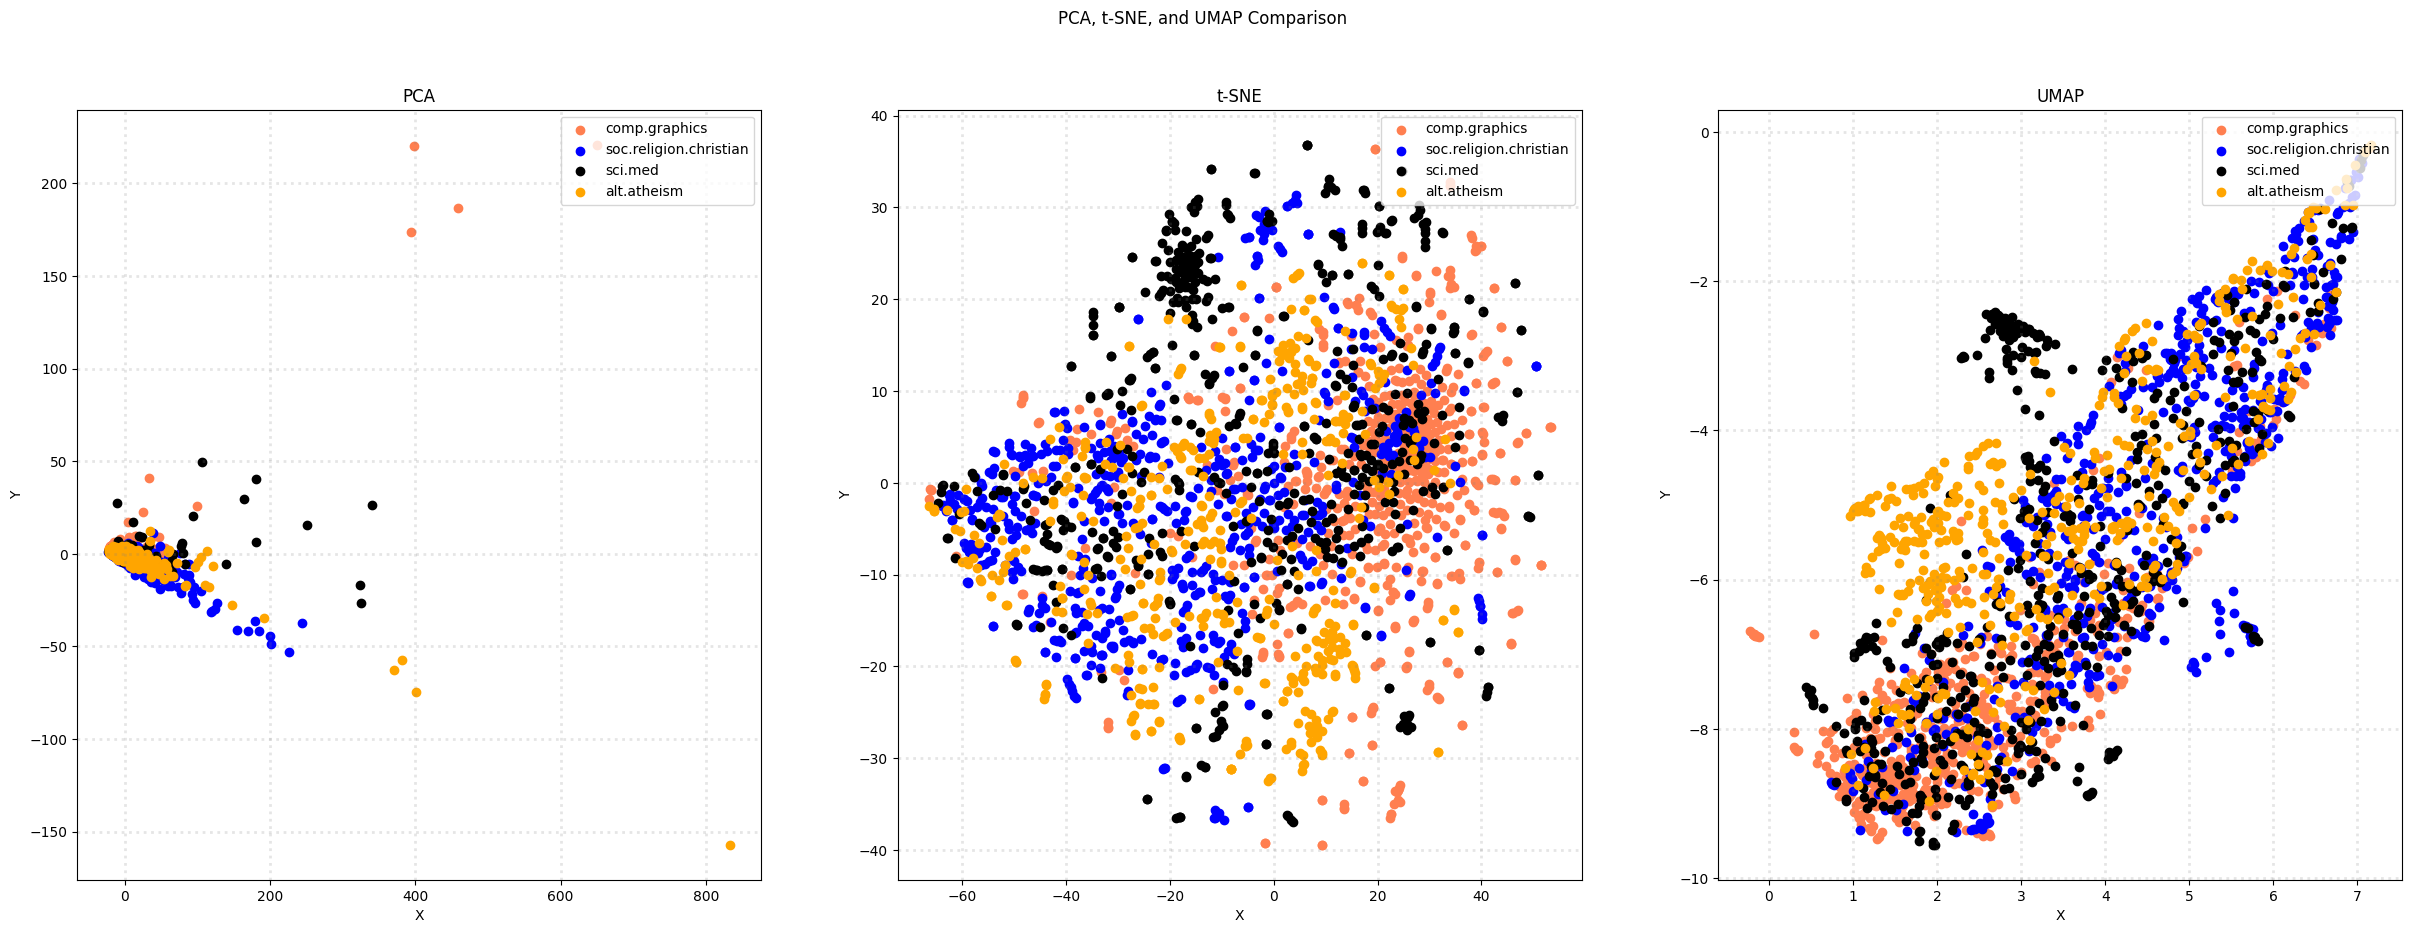

In [134]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique() 

fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_tdm, 'PCA')
plot_scatter(axes[1], X_tsne_tdm, 't-SNE')
plot_scatter(axes[2], X_umap_tdm, 'UMAP')

plt.show()

<span style="color:red">The plots generated by the above code may looks slightly different from those in the tutorial video. It is normal behavior due to some update of the PAMI library</span>

From the 2D PCA visualization above, we can see a slight "hint of separation in the data"; i.e., they might have some special grouping by category, but it is not immediately clear. In the t-SNE graph we observe a more scattered distribution, but still intermixing with all the categories. And with the UMAP graph, the limits for the data seem pretty well defined, two categories seem to have some points well differentiated from the other classes, but most of them remain intermixed. The algorithms were applied to the raw frequencies and this is considered a very naive approach as some words are not really unique to a document. Only categorizing by word frequency is considered a "bag of words" approach. Later on in the course you will learn about different approaches on how to create better features from the term-vector matrix, such as term-frequency inverse document frequency so-called TF-IDF.

Now let's try in tandem with our pattern augmented data:

In [135]:
#This might take a couple of minutes to execute
#Applying dimensionality reduction with both the document-term frequency data and the pattern derived data
# Apply PCA, t-SNE, and UMAP to the data
X_pca_aug = PCA(n_components=2).fit_transform(augmented_df.values)
X_tsne_aug = TSNE(n_components=2).fit_transform(augmented_df.values)
X_umap_aug = umap.UMAP(n_components=2).fit_transform(augmented_df.values)

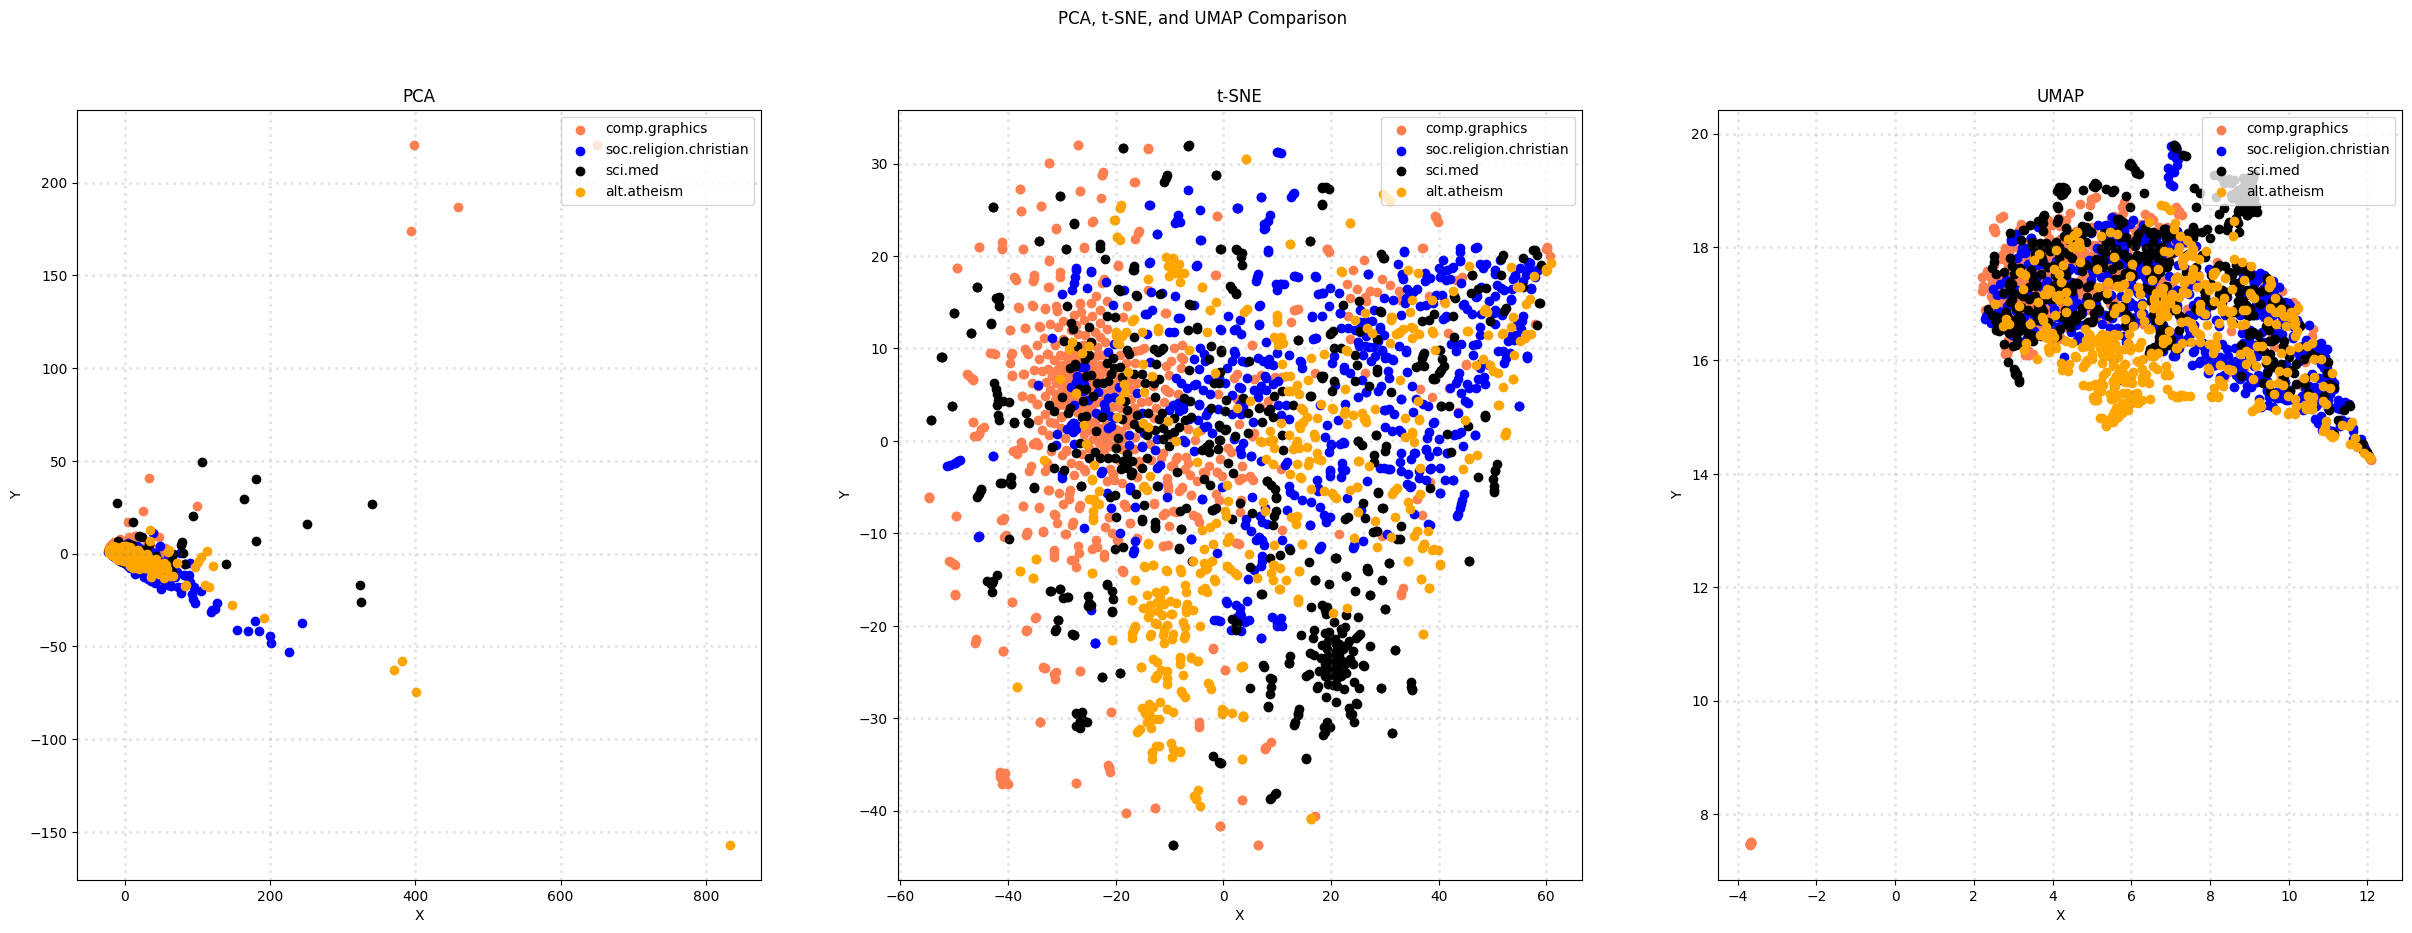

In [136]:
# Plot the results in subplots
col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique() 

fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

# Define a function to create a scatter plot for each method
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], X_pca_aug, 'PCA')
plot_scatter(axes[1], X_tsne_aug, 't-SNE')
plot_scatter(axes[2], X_umap_aug, 'UMAP')

plt.show()

<span style="color:red">The plots generated by the above code may looks slightly different from those in the tutorial video. It is normal behavior due to some update of the PAMI library</span>

We can see that our PCA visualization hasn't changed much from the previous version. This is likely because the original document-term matrix still dominates what the algorithm captures, overshadowing the new binary pattern data we added.

Looking at the t-SNE graph, it might seem different at first glance. However, upon closer inspection, it's almost the same but mirrored along the y-axis, with only slight changes in how the data points are placed. This similarity might be due to the stability of the t-SNE algorithm. Even small changes in the data can result in embeddings that look different but are structurally similar, indicating that the binary patterns may not have significantly altered the relationships among the data points in high-dimensional space.

The UMAP visualization shows the most noticeable changes—it appears more compact. This compactness could be because UMAP uses a more complex distance metric, which might be making it easier to see differences between closer and further points. The binary patterns could also be helping to reduce noise within categories, resulting in clearer, more coherent groups. However, the categories still appear quite mixed together.

Remember, just because you can't see clear groups in these visualizations doesn’t mean that a machine learning model won’t be able to classify the data correctly. These techniques are mainly used to help us see and understand complex data in a simpler two or three-dimensional space. However, they have their limits and might not show everything a computer model can find in the data. So, while these tools are great for getting a first look at your data, always use more methods and analyses to get the full picture.

### >>> Exercise 18 (take home):
Please try to reduce the dimension to 3, and plot the result use 3-D plot. Use at least 3 different angle (camera position) to check your result and describe what you found.

$Hint$: you can refer to Axes3D in the documentation.

In [137]:
X_pca_3d = PCA(n_components=3).fit_transform(augmented_df.values)
X_tsne_3d = TSNE(n_components=3).fit_transform(augmented_df.values)
X_umap_3d = umap.UMAP(n_components=3).fit_transform(augmented_df.values)

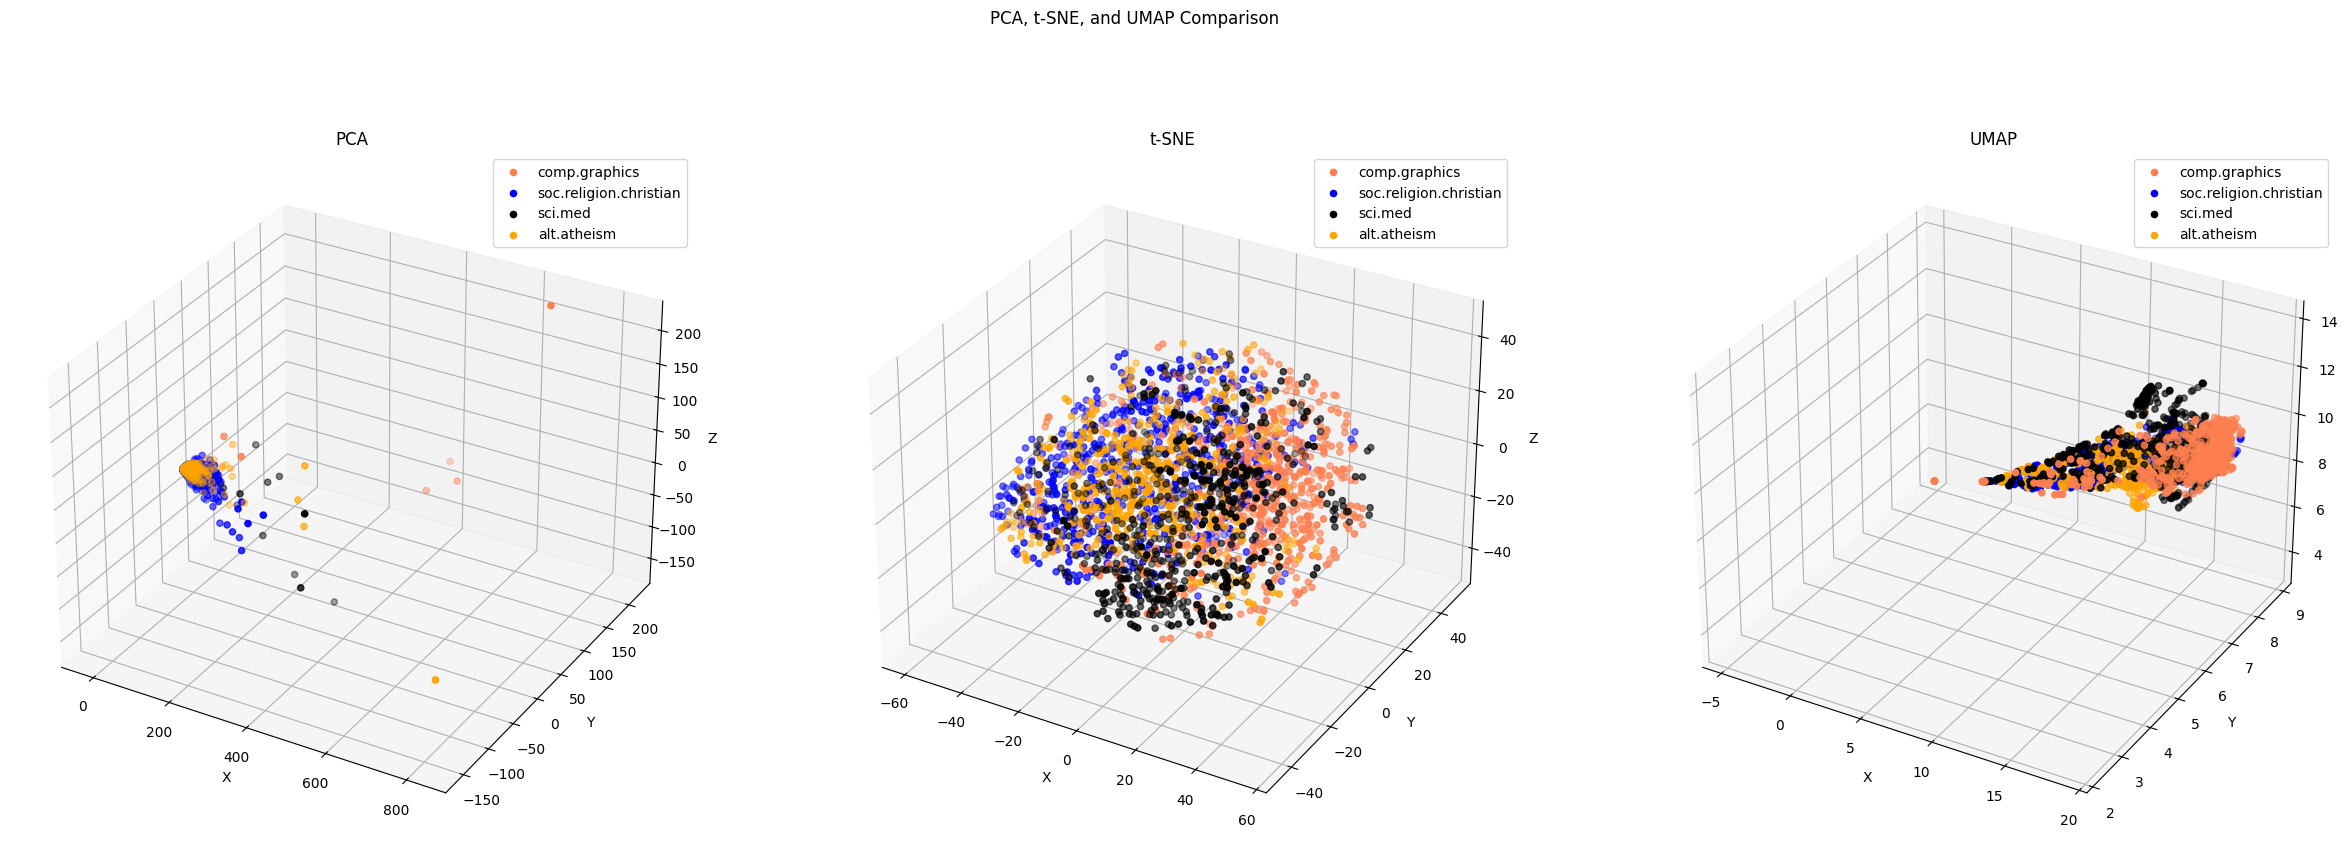

PCA is linear and can't capture complex nonlinear relationships in the data.
t-SNE captures nonlinear manifolds and local neighborhood structures, producing a clearer view of relationships between topics.
UMAP seems to balance cluster separation and global topology, making it useful for identifying distinct topic groups.


In [138]:
#Answer Here
from mpl_toolkits.mplot3d import Axes3D



col = ['coral', 'blue', 'black', 'orange']
categories = X['category_name'].unique() 
fig = plt.figure(figsize=(30, 10))
# fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Create 3 subplots for PCA, t-SNE, and UMAP
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
fig.suptitle('PCA, t-SNE, and UMAP Comparison')
ax = Axes3D(fig, rect=[0, 0, 0.33, 1], elev=30, azim=120)
def plot_scatter_3d(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        zs = X_reduced[X['category_name'] == category].T[2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z') 
    ax.legend(loc='upper right')


plot_scatter_3d(ax1, X_pca_3d, 'PCA')
plot_scatter_3d(ax2, X_tsne_3d, 't-SNE')
plot_scatter_3d(ax3, X_umap_3d, 'UMAP')

#plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("PCA is linear and can't capture complex nonlinear relationships in the data.")
print("t-SNE captures nonlinear manifolds and local neighborhood structures, producing a clearer view of relationships between topics.")
print("UMAP seems to balance cluster separation and global topology, making it useful for identifying distinct topic groups.")



---

### 5.6 Discretization and Binarization
In this section we are going to discuss a very important pre-preprocessing technique used to transform the data, specifically categorical values, into a format that satisfies certain criteria required by particular algorithms. Given our current original dataset, we would like to transform one of the attributes, `category_name`, into four binary attributes. In other words, we are taking the category name and replacing it with a `n` asymmetric binary attributes. The logic behind this transformation is discussed in detail in the recommended Data Mining text book (please refer to it on page 58). People from the machine learning community also refer to this transformation as one-hot encoding, but as you may become aware later in the course, these concepts are all the same, we just have different prefrence on how we refer to the concepts. Let us take a look at what we want to achieve in code. 

In [139]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

In [140]:
mlb = preprocessing.LabelBinarizer()

In [141]:
mlb.fit(X.category)

LabelBinarizer()

In [142]:
X['bin_category'] = mlb.transform(X['category']).tolist()

In [143]:
X[0:9]

,text,category,category_name,unigrams,tokenized_text,bin_category
0,From: sd345@city.ac.uk (Michael Collier) Subje...,1,comp.graphics,"[From, :, sd345, @, city.ac.uk, (, Michael, Co...","{HP, would, same,, files., Collier, (standard,...","[0, 1, 0, 0]"
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar) ...,1,comp.graphics,"[From, :, ani, @, ms.uky.edu, (, Aniruddha, B....","{can, would, area...then, help, rectangular, a...","[0, 1, 0, 0]"
2,From: djohnson@cs.ucsd.edu (Darin Johnson) Sub...,3,soc.religion.christian,"[From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...","{would, still, post, they, seeing, (Darin, Joh...","[0, 0, 0, 1]"
3,From: s0612596@let.rug.nl (M.M. Zwart) Subject...,3,soc.religion.christian,"[From, :, s0612596, @, let.rug.nl, (, M.M, ., ...","{Organization:, Groningen,, german, at, poland...","[0, 0, 0, 1]"
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian,"[From, :, stanly, @, grok11.columbiasc.ncr.com...","{marriage, find, Which, unto, clothes., theref...","[0, 0, 0, 1]"
5,From: vbv@lor.eeap.cwru.edu (Virgilio (Dean) B...,3,soc.religion.christian,"[From, :, vbv, @, lor.eeap.cwru.edu, (, Virgil...","{agree, wrong., medical, Jewish, precisely, wo...","[0, 0, 0, 1]"
6,From: jodfishe@silver.ucs.indiana.edu (joseph ...,3,soc.religion.christian,"[From, :, jodfishe, @, silver.ucs.indiana.edu,...","{can, especially, would, over, they, fisher), ...","[0, 0, 0, 1]"
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med,"[From, :, aldridge, @, netcom.com, (, Jacqueli...","{pores, over, pchurch@swell.actrix.gen.nz, hel...","[0, 0, 1, 0]"
8,From: geb@cs.pitt.edu (Gordon Banks) Subject: ...,2,sci.med,"[From, :, geb, @, cs.pitt.edu, (, Gordon, Bank...","{types, >blue-yellow., color-blindness, cones,...","[0, 0, 1, 0]"


Take a look at the new attribute we have added to the `X` table. You can see that the new attribute, which is called `bin_category`, contains an array of 0's and 1's. The `1` is basically to indicate the position of the label or category we binarized. If you look at the first two records, the one is places in slot 2 in the array; this helps to indicate to any of the algorithms which we are feeding this data to, that the record belong to that specific category. 

Attributes with **continuous values** also have strategies to tranform the data; this is usually called **Discretization** (please refer to the text book for more inforamation).

---

### >>> **Exercise 19 (take home):**
Try to generate the binarization using the `category_name` column instead. Does it work?

In [148]:
# Answer here
mlb2 = preprocessing.LabelBinarizer()
mlb2.fit(X.category_name)
X['bin_category_name'] = mlb2.transform(X['category_name']).tolist()
print(X[0:9][['category_name','bin_category_name']])
print("Yes, we can use LabelBinarizer to convert the 'category_name' column into binary format. \nThis is useful for multi-class classification tasks where each category needs to be represented as a binary vector.")

            category_name bin_category_name
0           comp.graphics      [0, 1, 0, 0]
1           comp.graphics      [0, 1, 0, 0]
2  soc.religion.christian      [0, 0, 0, 1]
3  soc.religion.christian      [0, 0, 0, 1]
4  soc.religion.christian      [0, 0, 0, 1]
5  soc.religion.christian      [0, 0, 0, 1]
6  soc.religion.christian      [0, 0, 0, 1]
7                 sci.med      [0, 0, 1, 0]
8                 sci.med      [0, 0, 1, 0]
Yes, we can use LabelBinarizer to convert the 'category_name' column into binary format. 
This is useful for multi-class classification tasks where each category needs to be represented as a binary vector.


---

# 6. Data Exploration

Sometimes you need to take a peek at your data to understand the relationships in your dataset. Here, we will focus in a similarity example. Let's take 3 documents and compare them.

In [149]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = X.iloc[10]
random_record_1 = random_record_1['text']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = X.iloc[100]
random_record_2 = random_record_2['text']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = X.iloc[1000]
random_record_3 = random_record_3['text']
document_to_transform_3.append(random_record_3)

Let's look at our emails.

In [150]:
print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

['From: anasaz!karl@anasazi.com (Karl Dussik) Subject: Re: Is "Christian" a dirty word? Organization: Anasazi Inc Phx Az USA Lines: 73  In article <Mar.25.03.53.08.1993.24855@athos.rutgers.edu> @usceast.cs.scarolina.edu:moss@cs.scarolina.edu (James Moss) writes: >I was brought up christian, but I am not christian any longer. >I also have a bad taste in my mouth over christianity.  I (in >my own faith) accept and live my life by many if not most of the >teachings of christ, but I cannot let myself be called a christian, >beacuse to me too many things are done on the name of christianity, >that I can not be associated with.    A question for you - can you give me the name of an organization or a philosophy or a political movement, etc., which has never had anything evil done in its name?  You\'re missing a central teaching of Christianity - man is inherently sinful.  We are saved through faith by grace.  Knowing that, believing that, does not make us without sin.  Furthermore, not all wh

In [151]:
from sklearn.preprocessing import binarize

# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [152]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.627571
Cosine Similarity using count bw 1 and 3: 0.713666
Cosine Similarity using count bw 2 and 3: 0.526166
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\452772485.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\452772485.py:14: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\452772485.py:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\452772485.py:17: DeprecationWarning:

Conversion of an array with ndim > 0 to a 

### >>> **Exercise 20 (take home):**
Try changing the texts reference for Text 1, Text 2, and Text 3. What do you observe from the Cosine Similarity results of different text references? following the modifications to texts reference, how can the results of the cosine similarity be interpreted?

In [157]:
#Answer

dt1 = []
rr1 = X.iloc[25]
rr1 = rr1['text']
dt1.append(rr1)

dt2 = []
rr2 = X.iloc[250]
rr2 = rr2['text']
dt2.append(rr2)

dt3 = []
rr3 = X.iloc[750]
rr3 = rr3['text']
dt3.append(rr3)

vc_1 = count_vect.transform(dt1)
vc_2 = count_vect.transform(dt2)
vc_3 = count_vect.transform(dt3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
vc_1_bin = binarize(vc_1)
vc_2_bin = binarize(vc_2)
vc_3_bin = binarize(vc_3)

css_1_2 = cosine_similarity(vc_1_bin, vc_2_bin, dense_output=True)
css_1_3 = cosine_similarity(vc_1_bin, vc_3_bin, dense_output=True)
css_2_3 = cosine_similarity(vc_2_bin, vc_3_bin, dense_output=True)

css_1_1 = cosine_similarity(vc_1_bin, vc_1_bin, dense_output=True)
css_2_2 = cosine_similarity(vc_2_bin, vc_2_bin, dense_output=True)
css_3_3 = cosine_similarity(vc_3_bin, vc_3_bin, dense_output=True)

print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":css_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":css_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":css_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":css_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":css_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":css_3_3})

print("We can see that the cosine similarity values are lower than that from the previous ones, \nindicating that the selected documents are different and have different content.")
print("The self-similarity values are 1, as expected, since they are compared with themselves.")
text = """Changing the text references directly affects cosine similarity scores because it alters the overlap of words or meanings between texts.
Higher values indicate stronger lexical or semantic alignment; lower values suggest divergence in topic or expression."""
print(text)


Cosine Similarity using count bw 1 and 2: 0.184865
Cosine Similarity using count bw 1 and 3: 0.163188
Cosine Similarity using count bw 2 and 3: 0.173465
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000
We can see that the cosine similarity values are lower than that from the previous ones, 
indicating that the selected documents are different and have different content.
The self-similarity values are 1, as expected, since they are compared with themselves.
Changing the text references directly affects cosine similarity scores because it alters the overlap of words or meanings between texts.
Higher values indicate stronger lexical or semantic alignment; lower values suggest divergence in topic or expression.


C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\2057366172.py:35: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\2057366172.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\2057366172.py:37: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\A2282\AppData\Local\Temp\ipykernel_27712\2057366172.py:39: DeprecationWarning:

Conversion of an array with ndim > 0 t

---

# 7. Data Classification
Data classification is one of the most critical steps in the final stages of the data mining process. After uncovering patterns, trends, or insights from raw data, classification helps organize and label the data into predefined categories. This step is crucial in making the mined data actionable, as it allows for accurate predictions and decision-making. For example, in text mining, classification can be used to categorize documents based on their content, like classifying news articles into categories such as sports, politics, or technology.
Among various classification techniques, the **Naive Bayes classifier** is a simple yet powerful algorithm commonly used for text classification tasks. Specifically, the Multinomial Naive Bayes classifier is particularly suited for datasets where features are represented by term frequencies, such as a document-term matrix, like the one we have.

- **Multinomial Naive Bayes:**
    The Multinomial Naive Bayes classifier works by assuming that the features (words or terms in text data) follow a multinomial distribution. In simple terms, it calculates the probability of a document belonging to a particular category based on the frequency of words in that document, assuming independence between words (the "naive" part of Naive Bayes). Despite this assumption, it often performs remarkably well for text data, especially when working with word count features. Now, when incorporating the binary matrix of patterns we have, it remains compatible because the binary values can be seen as a count of pattern occurrences (1 for present, 0 for absent). Although binary features are not true "counts," the Multinomial Naive Bayes classifier can still handle them without issue. For more information you can go to: [NB Classifier](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/)
    
We will implement a Multinomial Naive Bayes, for that we first choose how to split our data, in this case we will follow a typical **70/30 split for the training and test set**. Let's see a comparison of what we obtain when classifying our data without patterns vs our data with the patterns.

In [158]:
#Model with only the document-term frequency data
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Create a mapping from numerical labels to category names
category_mapping = dict(X[['category', 'category_name']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, X['category'], test_size=0.3, random_state=42)

In [ ]:
X_train

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,zvi,zvonko,zwart,zyeh,zyklon,zyxel,zz,zzz,ªl,íålittin
634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test

,00,000,0000,0000001200,000005102000,0001,000100255pixel,00014,000406,0007,...,zvi,zvonko,zwart,zyeh,zyklon,zyxel,zz,zzz,ªl,íålittin
561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1513,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.9660766961651918

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism     0.9535    0.9535    0.9535       129
         comp.graphics     0.9540    0.9822    0.9679       169
               sci.med     0.9839    0.9683    0.9760       189
soc.religion.christian     0.9683    0.9581    0.9632       191

              accuracy                         0.9661       678
             macro avg     0.9649    0.9655    0.9651       678
          weighted avg     0.9663    0.9661    0.9661       678



### >>> **Exercise 21 (take home):**

Previously, we performed data augmentation by concatenating the original TDM with the pattern matrix. Use the augmented data to perform classification using Naive Bayes as in the previous steps.

In [160]:
#Answer
nb = MultinomialNB()
X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(augmented_df, X['category'], test_size=0.3, random_state=42)
nb.fit(X_aug_train, y_aug_train)
y_aug_pred = nb.predict(X_aug_test)
print("Accuracy:", accuracy_score(y_aug_test, y_aug_pred))
print("\nClassification Report:\n", classification_report(y_aug_test, y_aug_pred, target_names=target_names, digits=4))


Accuracy: 0.9734513274336283

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism     0.9837    0.9380    0.9603       129
         comp.graphics     0.9940    0.9822    0.9881       169
               sci.med     0.9789    0.9841    0.9815       189
soc.religion.christian     0.9444    0.9791    0.9614       191

              accuracy                         0.9735       678
             macro avg     0.9753    0.9709    0.9728       678
          weighted avg     0.9739    0.9735    0.9735       678



### >>> **Exercise 22 (take home):**

What differences can be observed between the results obtained using the original TDM and those obtained using the augmented TDM?

In [161]:
#Answer
print("By incorporating pattern-derived features, the model captures more complex relationships and contextual information within the text data.")
print("This leads to improved classification accuracy and a more nuanced understanding of the categories, as evidenced by the enhanced performance metrics.")

By incorporating pattern-derived features, the model captures more complex relationships and contextual information within the text data.
This leads to improved classification accuracy and a more nuanced understanding of the categories, as evidenced by the enhanced performance metrics.


### Decision Tree Classifier
Another popular classification technique is the **Decision Tree classifier**. Decision Trees work by recursively splitting the data into subsets based on feature values, creating a tree-like model of decisions. Each node in the tree represents a feature, and each branch represents a decision rule. The leaves represent the final class labels.

- **Decision Tree:**
    Decision Trees are intuitive and easy to visualize. They can handle both numerical and categorical data and do not require feature scaling. However, they can be prone to overfitting, especially with high-dimensional data. In text classification, Decision Trees can be used with document-term matrices or augmented feature sets, just like Naive Bayes.

In the following code, we will train and evaluate a Decision Tree classifier on both the document-term matrix and the augmented data (with patterns), allowing us to compare its performance with the Naive Bayes model.
    
We will implement a Multinomial Naive Bayes, for that we first choose how to split our data, in this case we will follow a typical **70/30 split for the training and test set**. Let's see a comparison of what we obtain when classifying our data without patterns vs our data with the patterns.

In [164]:
# Decision Tree with only the document-term frequency data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split the data (already done above, but shown here for clarity)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, X['category'], test_size=0.3, random_state=42)

# Train Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_classifier.predict(X_test)
print("Decision Tree Accuracy (TDM):", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, target_names=target_names, digits=4))

Decision Tree Accuracy (TDM): 0.7713864306784661

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism     0.7500    0.7907    0.7698       129
         comp.graphics     0.7486    0.7929    0.7701       169
               sci.med     0.7571    0.7090    0.7322       189
soc.religion.christian     0.8226    0.8010    0.8117       191

              accuracy                         0.7714       678
             macro avg     0.7696    0.7734    0.7710       678
          weighted avg     0.7721    0.7714    0.7712       678



### >>> **Exercise 23 (take home):**

Why do you think the performance of Decision Trees is lower than that of Naive Bayes? Provide possible reasons.

In [162]:
#Answer
text ="""Naive Bayes > Decision Tree in text classification because:

Text features are high-dimensional and sparse.

NB’s independence assumption fits the bag-of-words model well.

Decision Trees overfit and can’t generalize on sparse vocabularies.

NB’s probabilistic approach handles unseen words better.

Trees’ discrete splitting is less effective for frequency-based word features."""
print(text)


Naive Bayes > Decision Tree in text classification because:

Text features are high-dimensional and sparse.

NB’s independence assumption fits the bag-of-words model well.

Decision Trees overfit and can’t generalize on sparse vocabularies.

NB’s probabilistic approach handles unseen words better.

Trees’ discrete splitting is less effective for frequency-based word features.


### >>> **Exercise 24 (take home):**

Implement using the augmented data, does the performance improve compared to that obtained with the original TDM? Is it better than Naive Bayes? Provide possible explanations for your observations.

In [165]:
#Answer
X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(augmented_df, X['category'], test_size=0.3, random_state=42)
aug_classifier = DecisionTreeClassifier(random_state=42)
aug_classifier.fit(X_aug_train, y_aug_train)
y_aug_pred = aug_classifier.predict(X_aug_test)
print("Decision Tree Accuracy (TDM):", accuracy_score(y_aug_test, y_aug_pred))
print("\nClassification Report:\n", classification_report(y_aug_test, y_aug_pred, target_names=target_names, digits=4))

Decision Tree Accuracy (TDM): 0.7654867256637168

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism     0.7820    0.8062    0.7939       129
         comp.graphics     0.7399    0.7574    0.7485       169
               sci.med     0.7249    0.7249    0.7249       189
soc.religion.christian     0.8197    0.7853    0.8021       191

              accuracy                         0.7655       678
             macro avg     0.7666    0.7685    0.7674       678
          weighted avg     0.7662    0.7655    0.7657       678



### >>> **Exercise 25 (take home):**

In your opinion, how should one choose the best model for a given task, such as the classification example above?

In [166]:
#Answer
print("Choosing the best model isn’t just about picking the one with the highest accuracy; \nit’s about matching the model to the nature of the data, task requirements, and practical constraints.")
print("Besides, text data converted into term-document matrices — high-dimensional, sparse → hence Naive Bayes is a strong natural fit.")
print("In general, the model with the best validation performance and stable generalization is your practical choice.")


Choosing the best model isn’t just about picking the one with the highest accuracy; 
it’s about matching the model to the nature of the data, task requirements, and practical constraints.
Besides, text data converted into term-document matrices — high-dimensional, sparse → hence Naive Bayes is a strong natural fit.
In general, the model with the best validation performance and stable generalization is your practical choice.


----

## 8. Concluding Remarks

Wow! We have come a long way! We can now call ourselves experts of Data Preprocessing. You should feel excited and proud because the process of Data Mining usually involves 70% preprocessing and 30% training learning models. You will learn this as you progress in the Data Mining course. I really feel that if you go through the exercises and challenge yourself, you are on your way to becoming a super Data Scientist. 

From here the possibilities for you are endless. You now know how to use almost every common technique for preprocessing with state-of-the-art tools, such as Pandas, Scikit-learn, UMAP and PAMI. You are now with the trend! 

After completing this notebook you can do a lot with the results we have generated. You can train algorithms and models that are able to classify articles into certain categories and much more. You can also try to experiment with different datasets, or venture further into text analytics by using new deep learning techniques such as word2vec. All of this will be presented in the next lab session. Until then, go teach machines how to be intelligent to make the world a better place. 

----

## 9. References

- Pandas cook book ([Recommended for starters](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html))
- [Pang-Ning Tan, Michael Steinbach, Vipin Kumar, Introduction to Data Mining, Addison Wesley](https://dl.acm.org/citation.cfm?id=1095618)